Baseline loaded for Bryan:
  HR: 86.2 bpm
  mNPV: 0.012308
  BP: 120/62 mmHg
  MAP: 81.3 mmHg

Train-test split:
  Training files: 13
  Test file: 4_may_bryan_4.csv

Processing 13 training files...
  Processed 4_may_bryan_1.csv (1/13)
  Processed 30_apr_bryan_4.csv (2/13)
  Processed 30_apr_bryan_5.csv (3/13)
  Processed 11may_bryan_1_test.csv (4/13)
  Processed 30_apr_bryan_6.csv (5/13)
  Processed 4_may_bryan_7.csv (6/13)
  Processed 30_apr_bryan_2.csv (7/13)
  Processed 30_apr_bryan_7.csv (8/13)
  Processed 4_may_bryan_6.csv (9/13)
  Processed 4_may_bryan_5.csv (10/13)
  Processed 30_apr_bryan_1.csv (11/13)
  Processed 4_may_bryan_2.csv (12/13)
  Processed 30_apr_bryan_3.csv (13/13)

Training models with 13 data points...

Model training complete:
  SBP model R²: 0.273
  DBP model R²: 0.053
  MAP model R²: 0.127

Processing 14 training files...
  Processed 4_may_bryan_4.csv (1/14)
  Processed 4_may_bryan_1.csv (2/14)
  Processed 30_apr_bryan_4.csv (3/14)
  Processed 30_apr_bryan_5.c

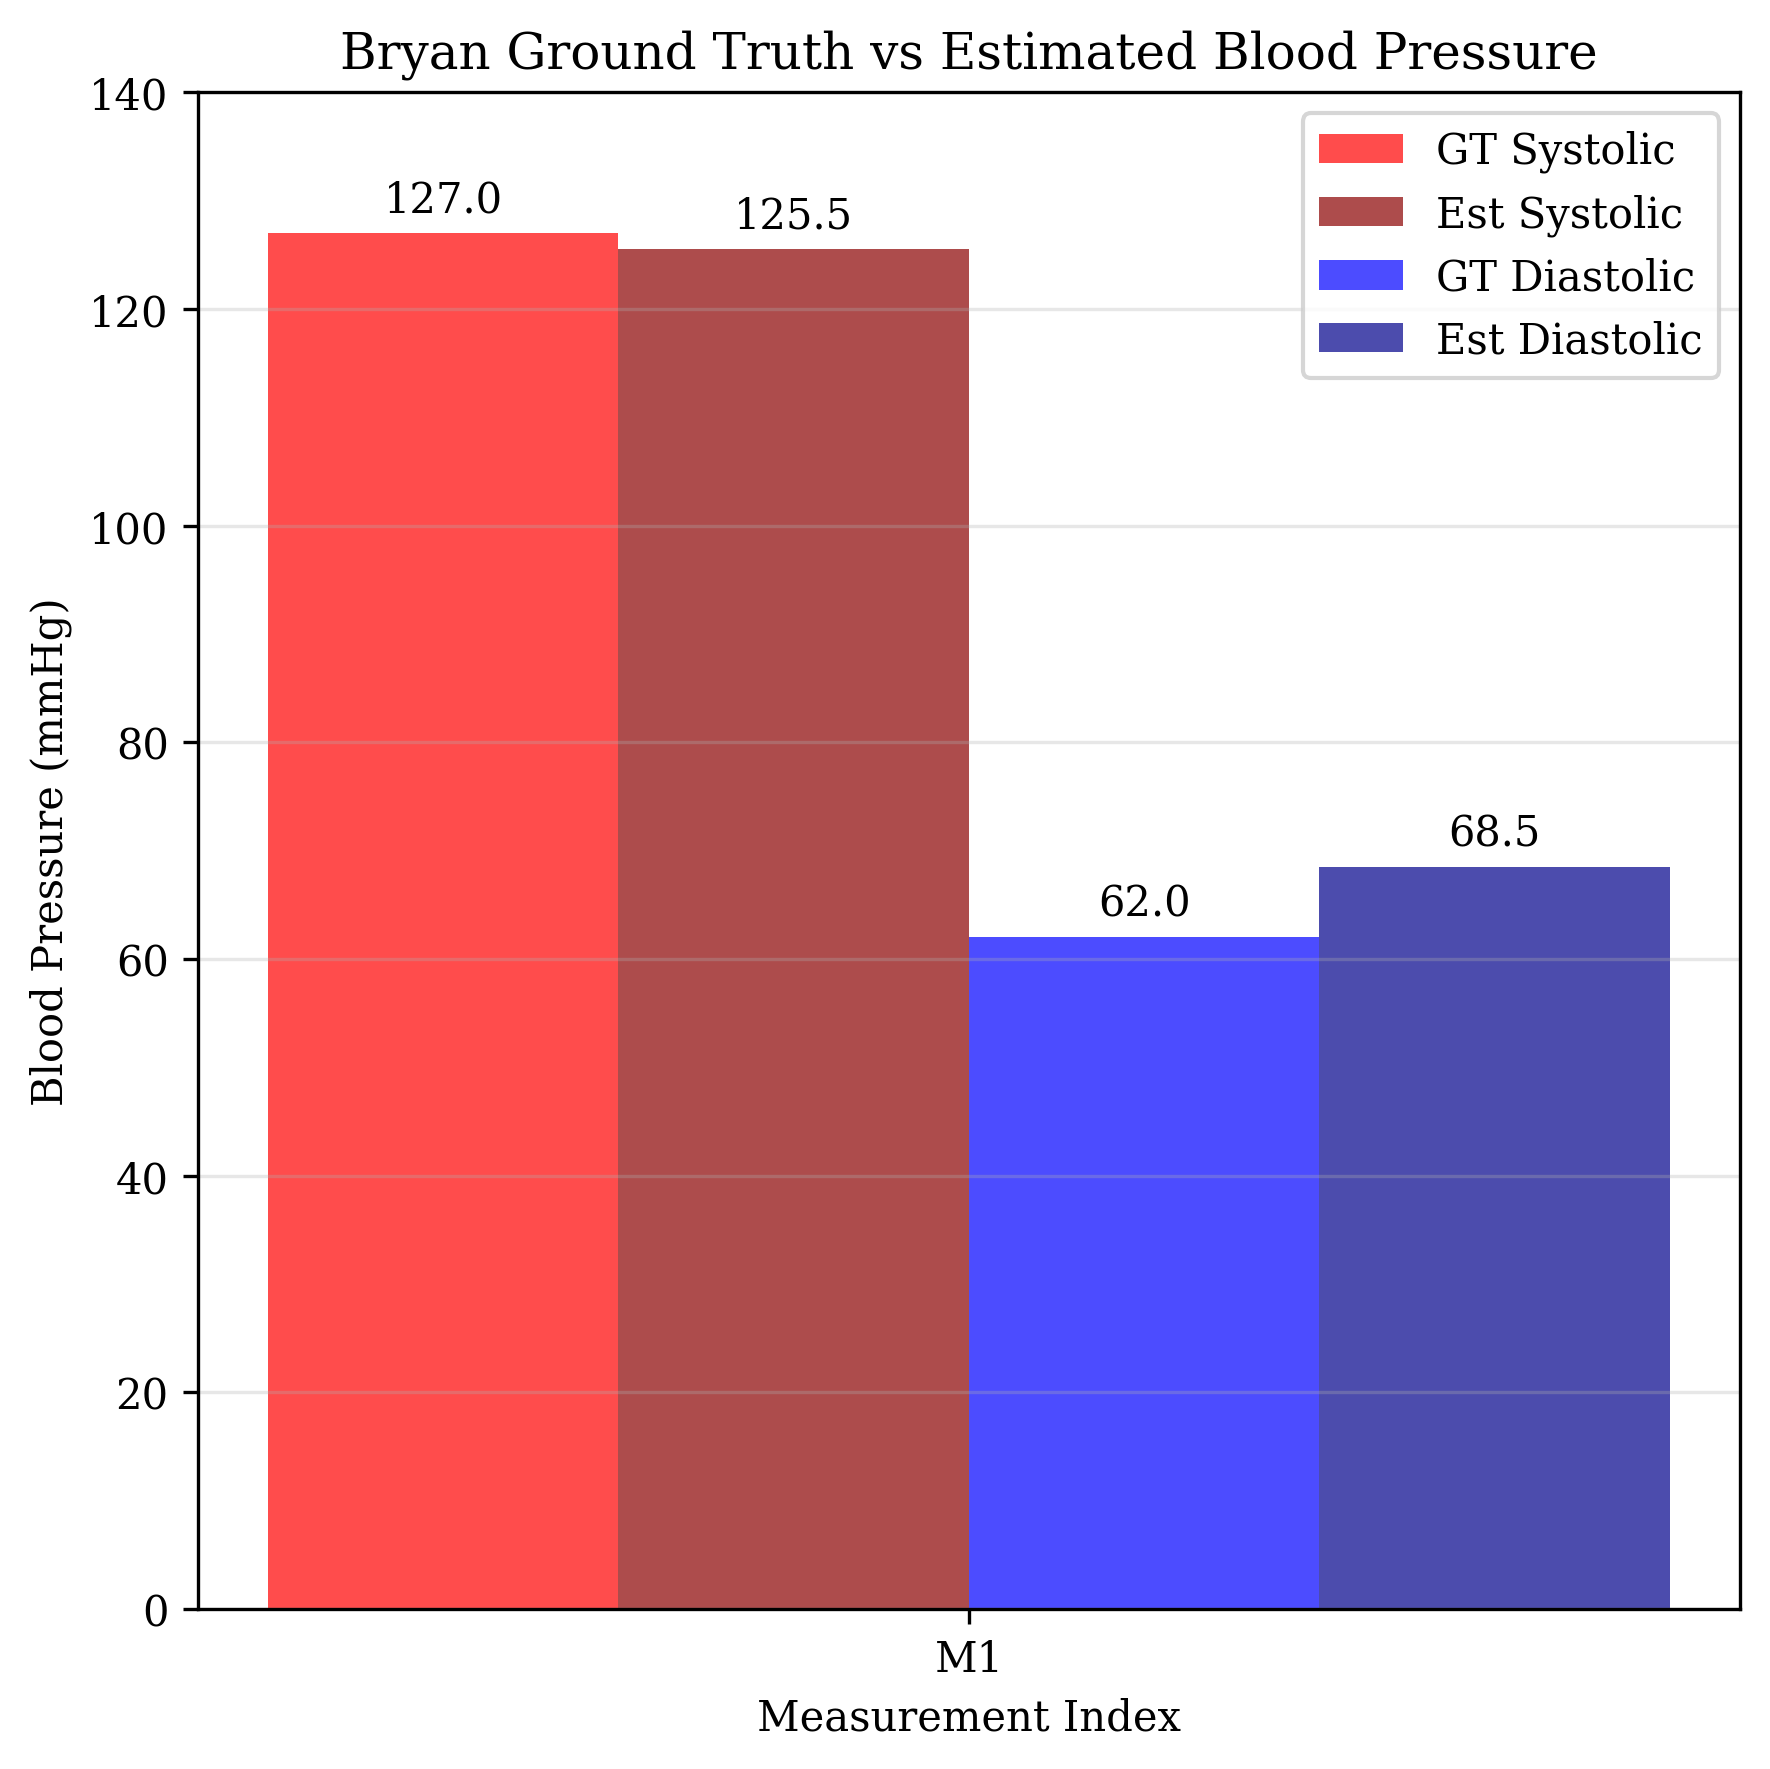

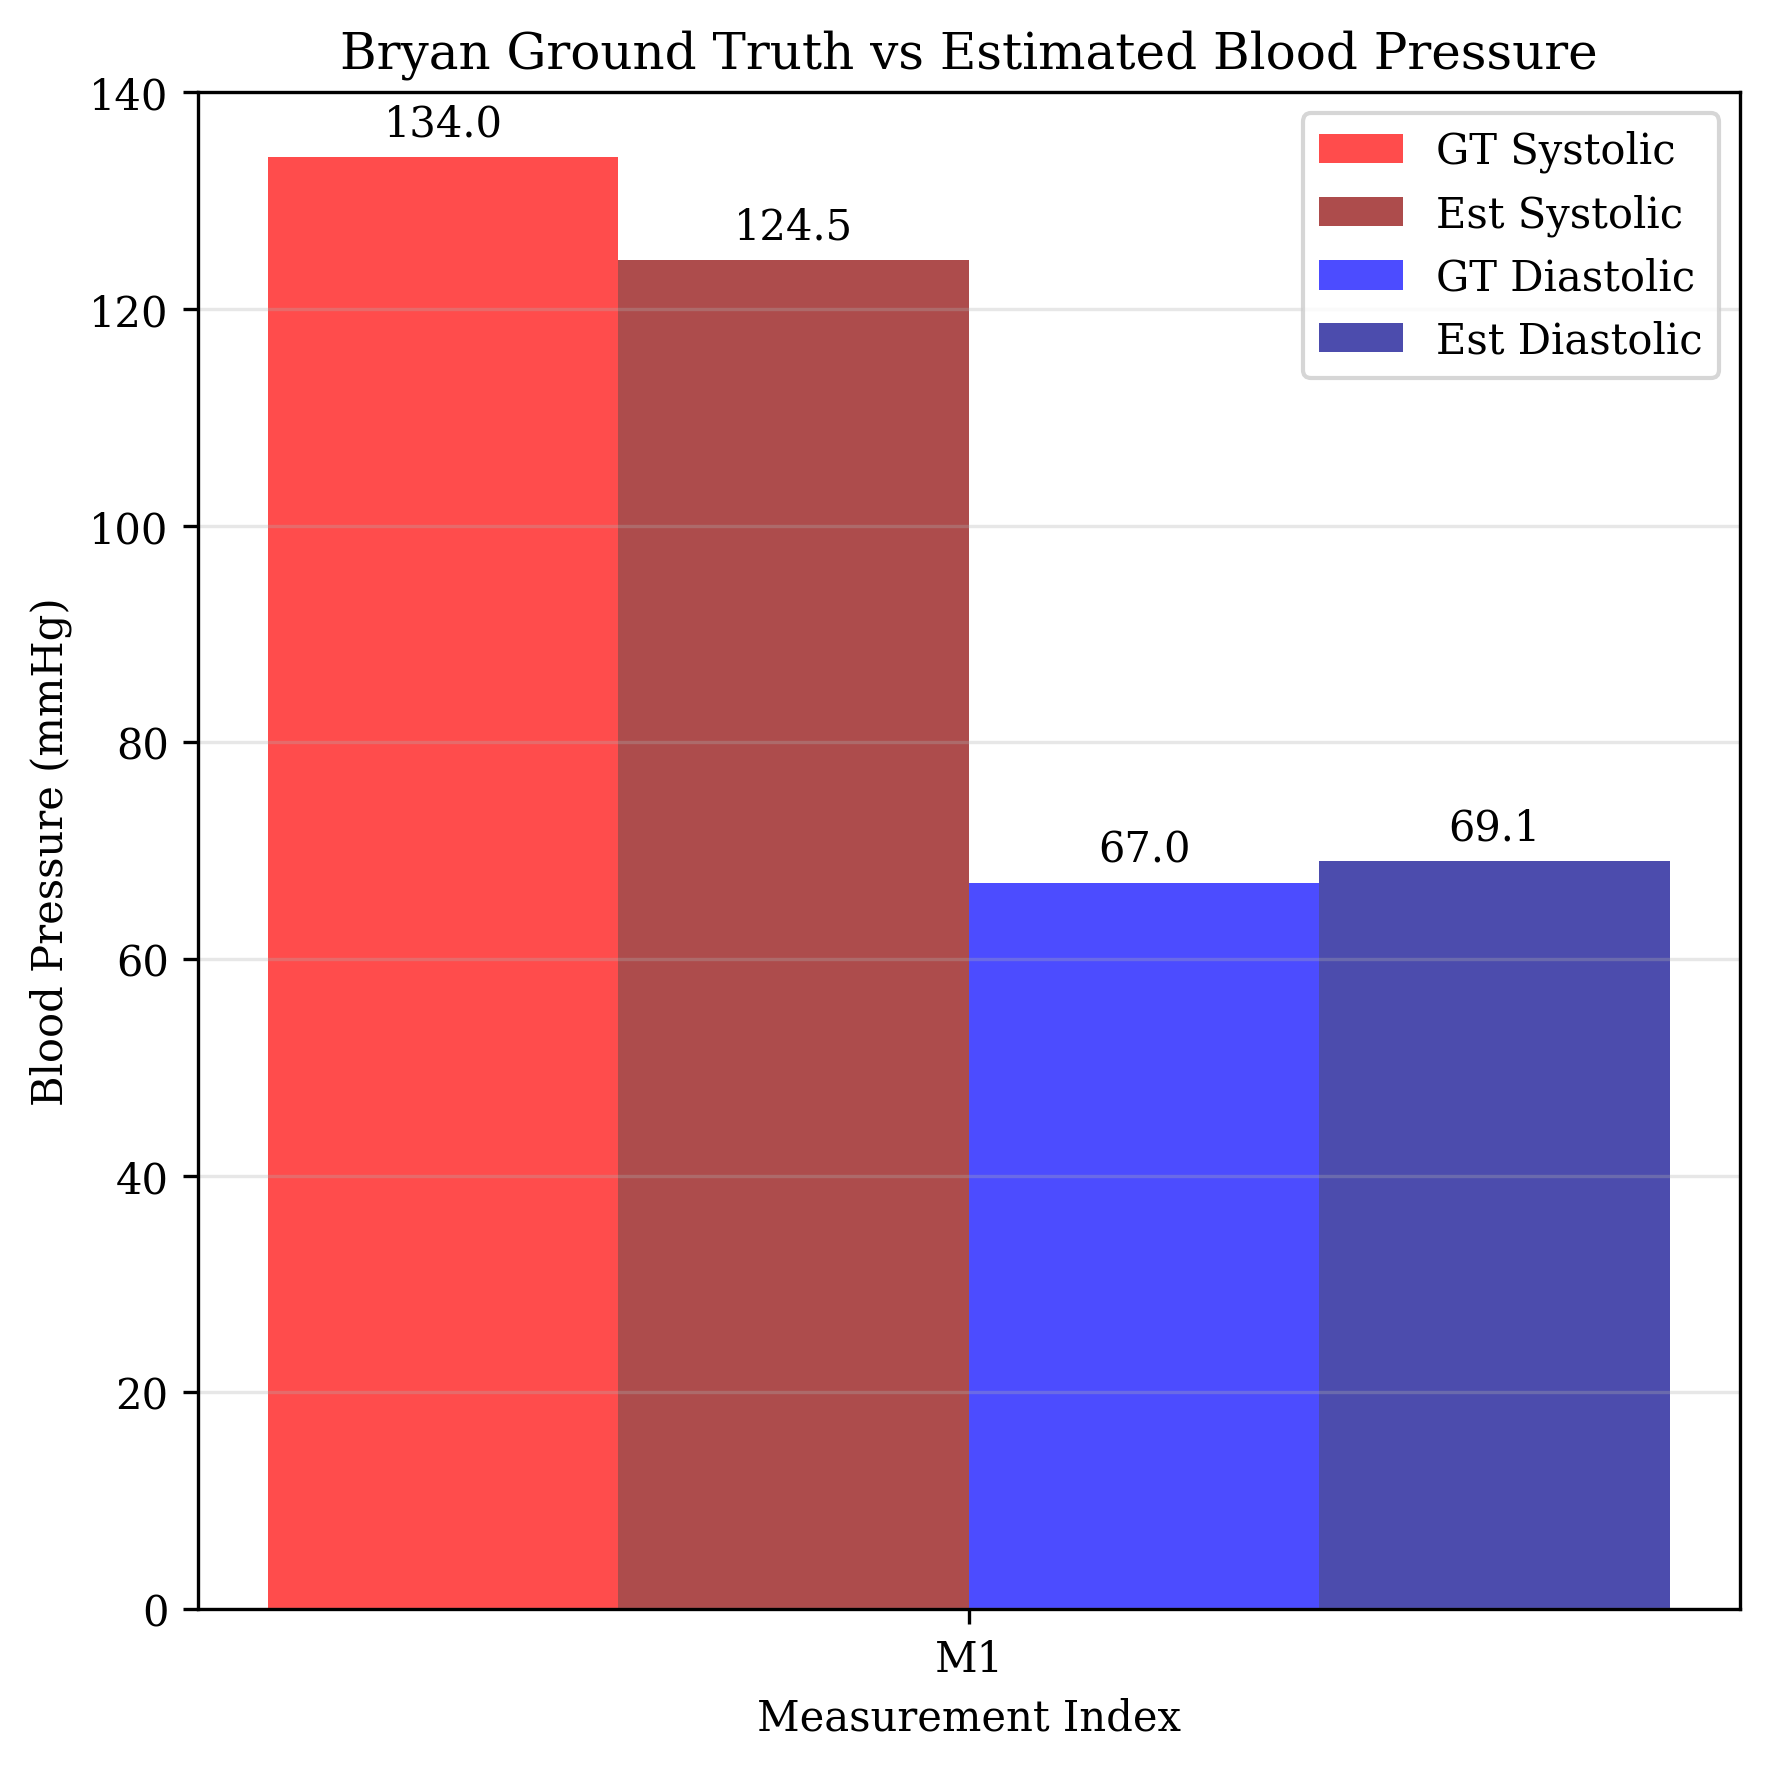

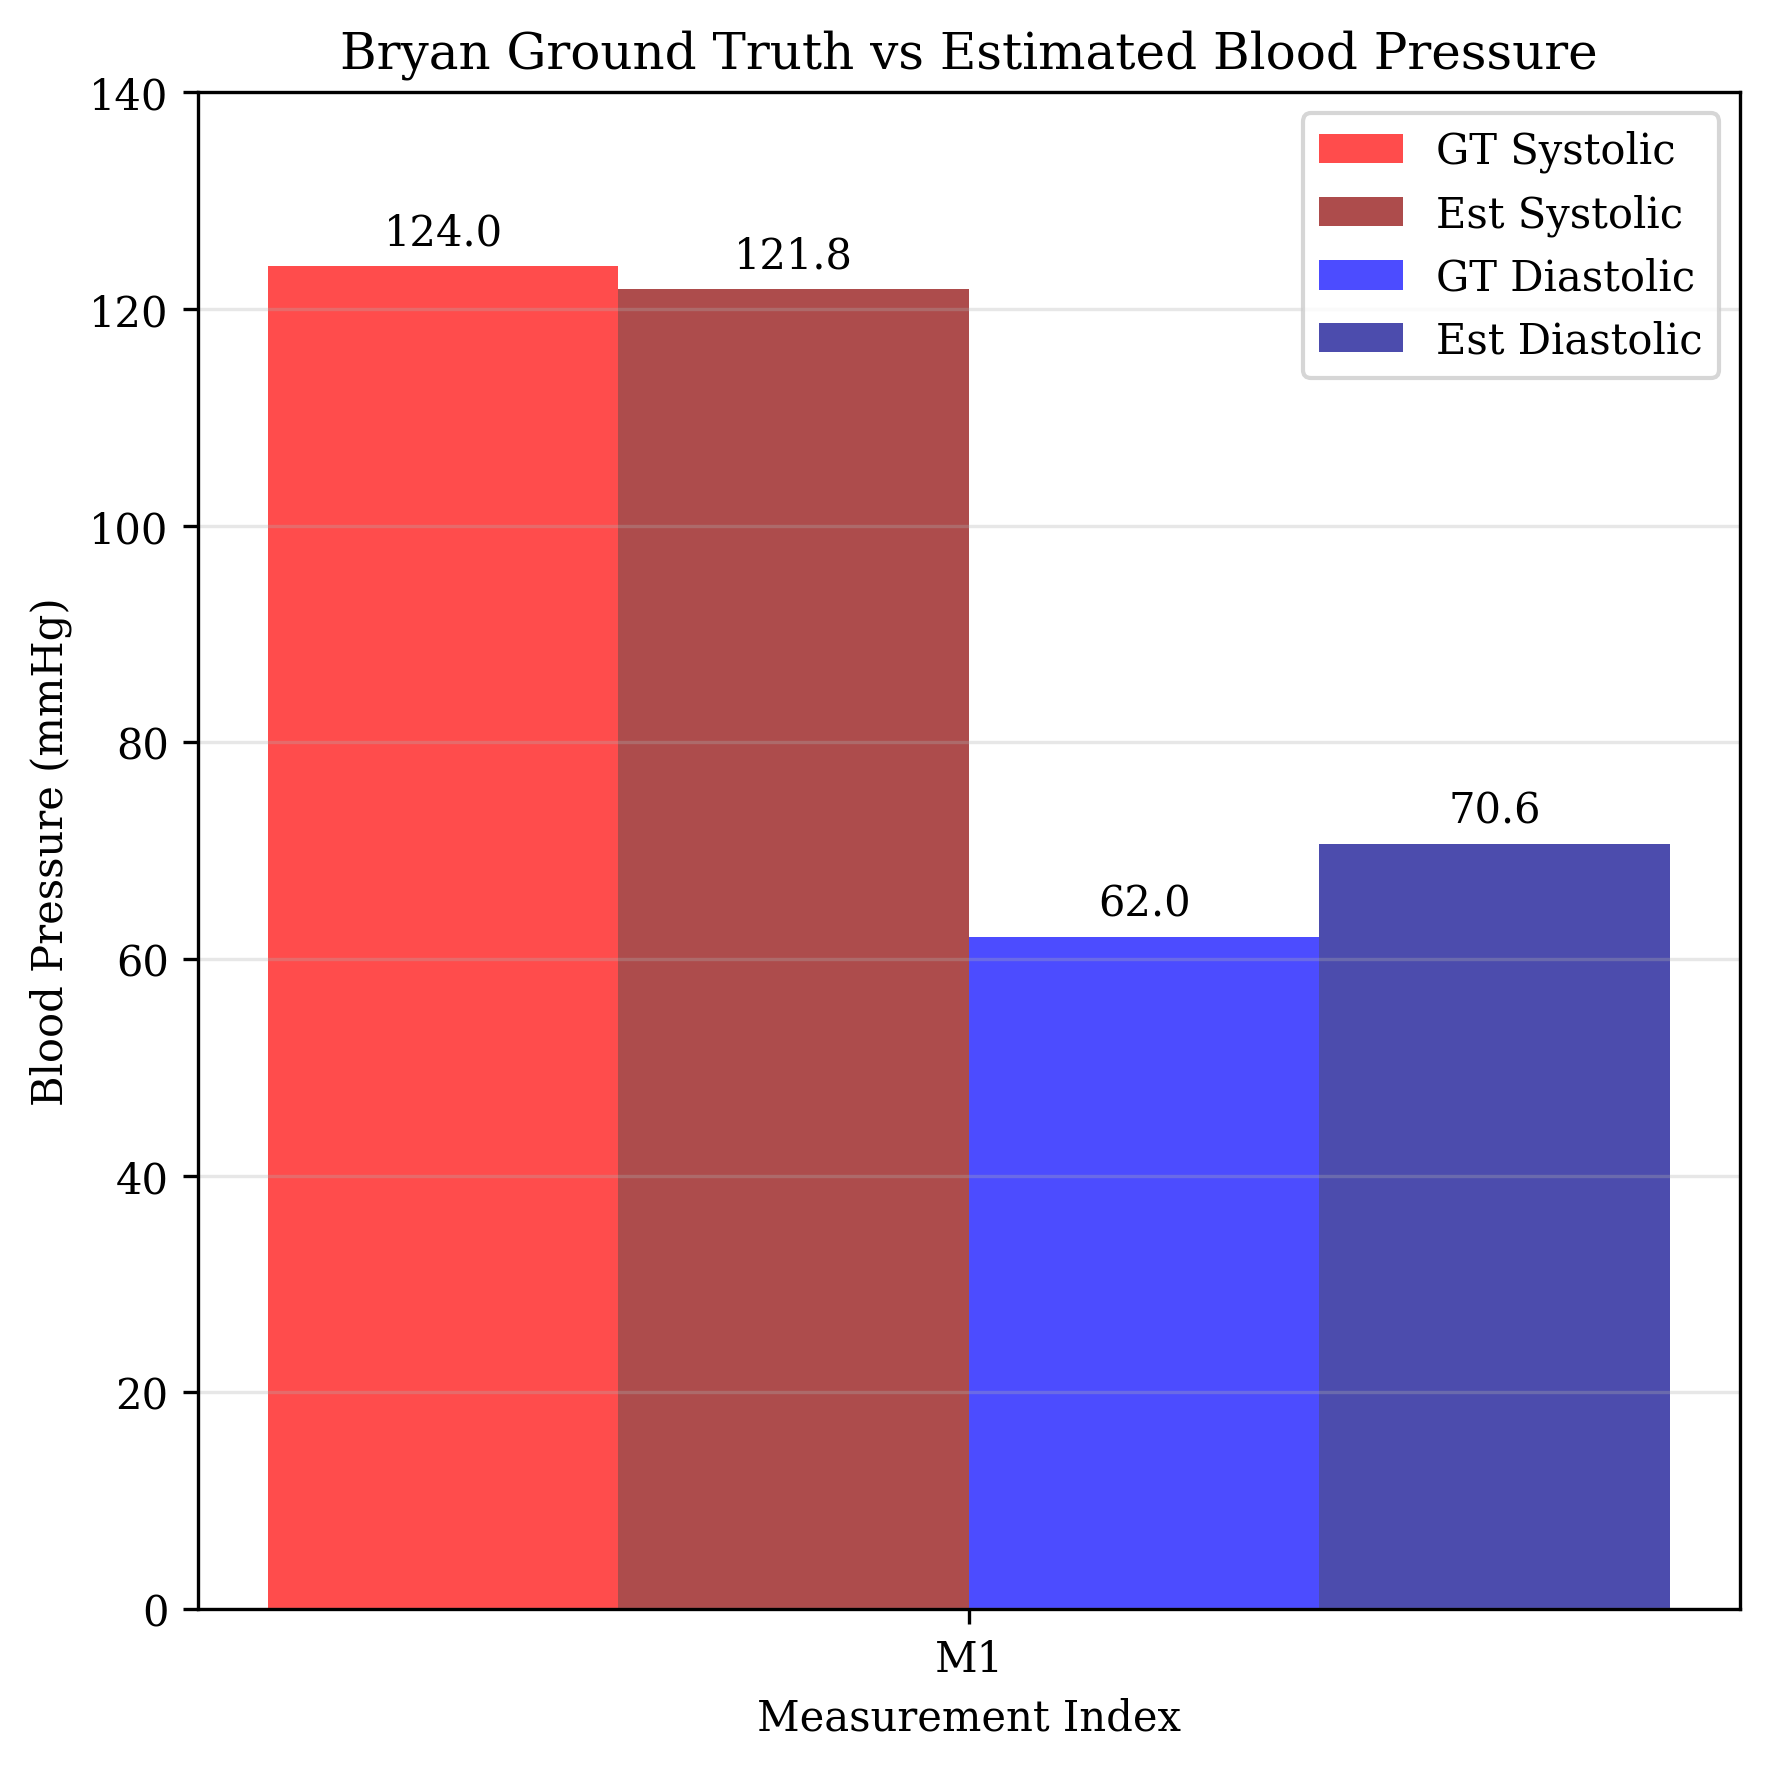

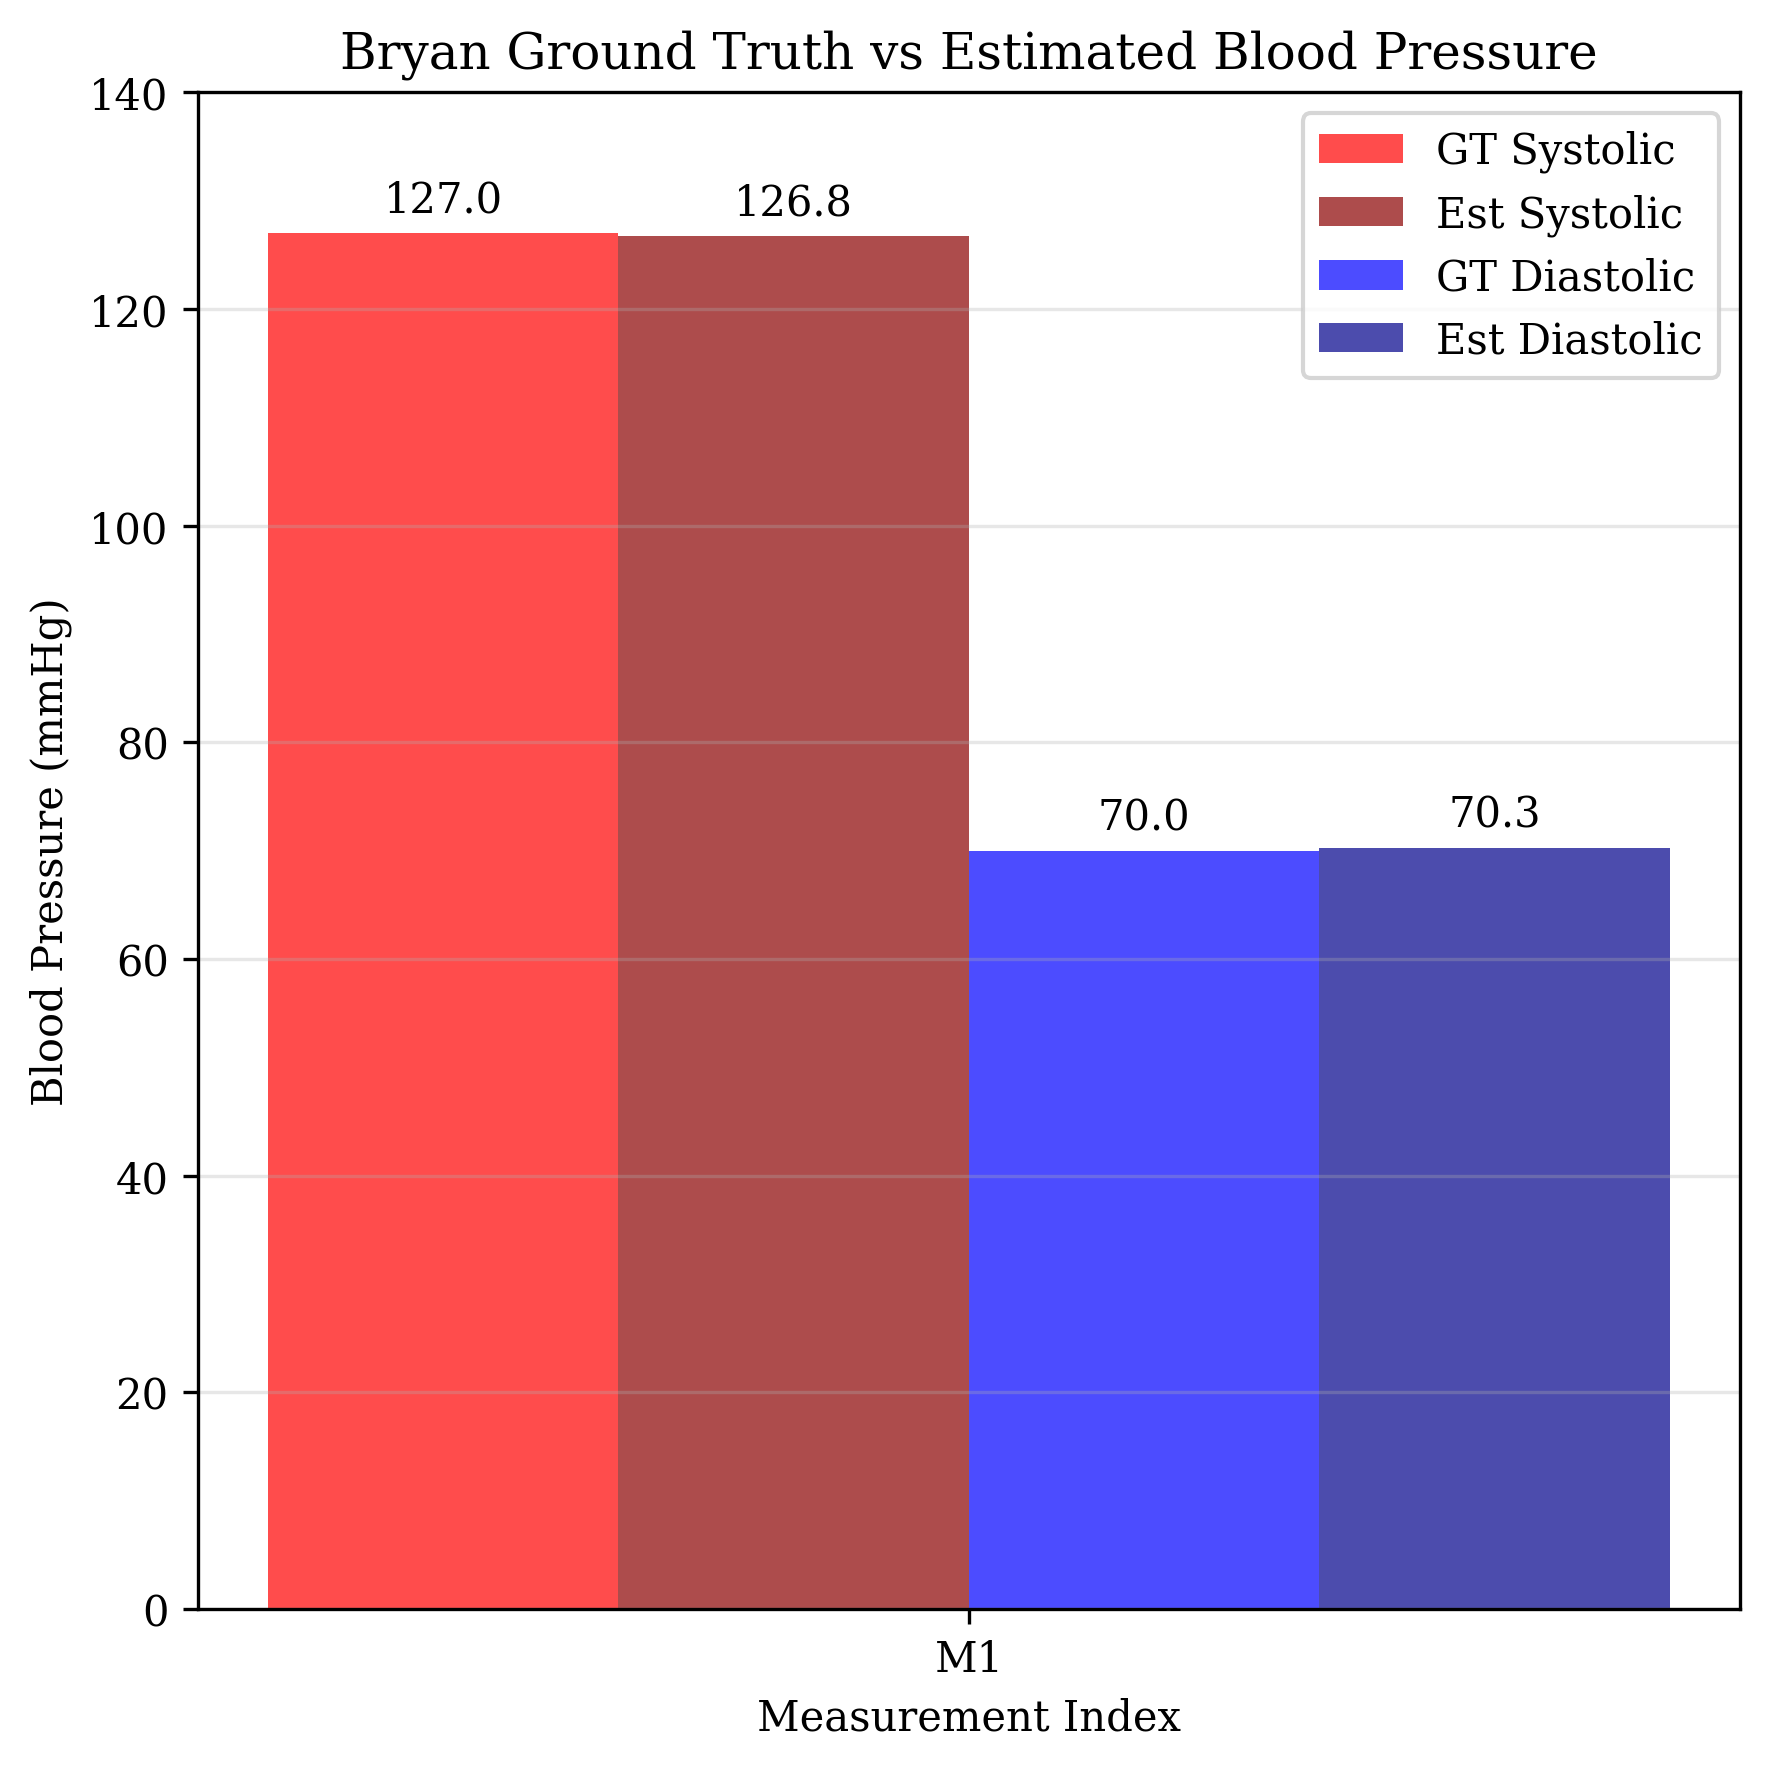

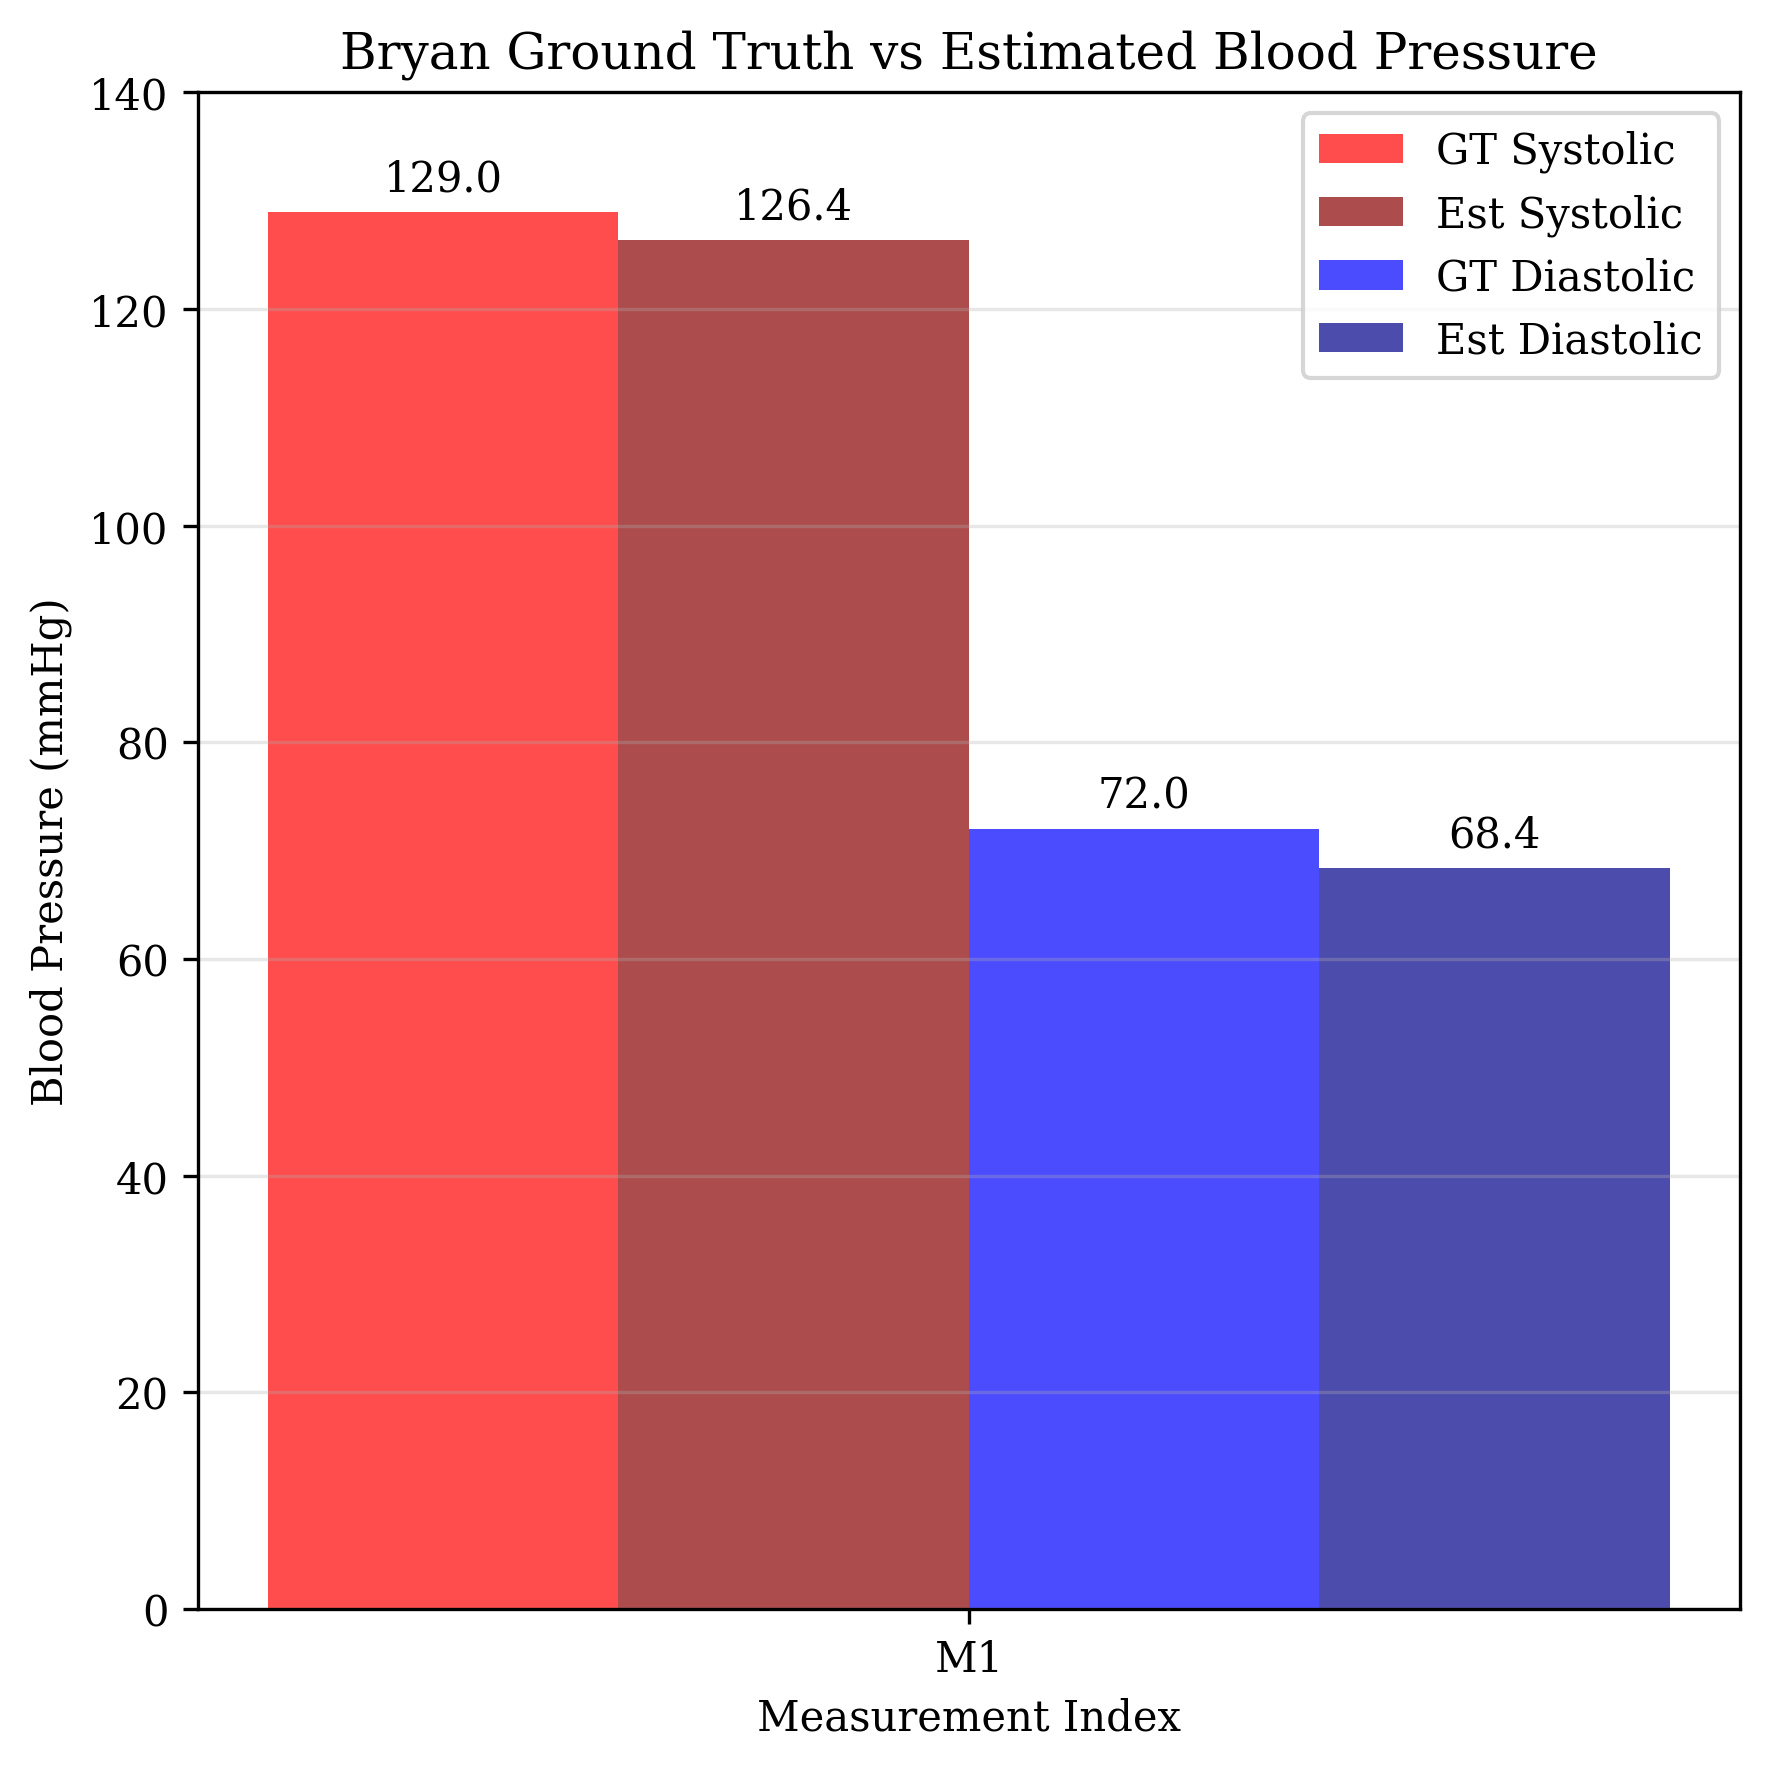

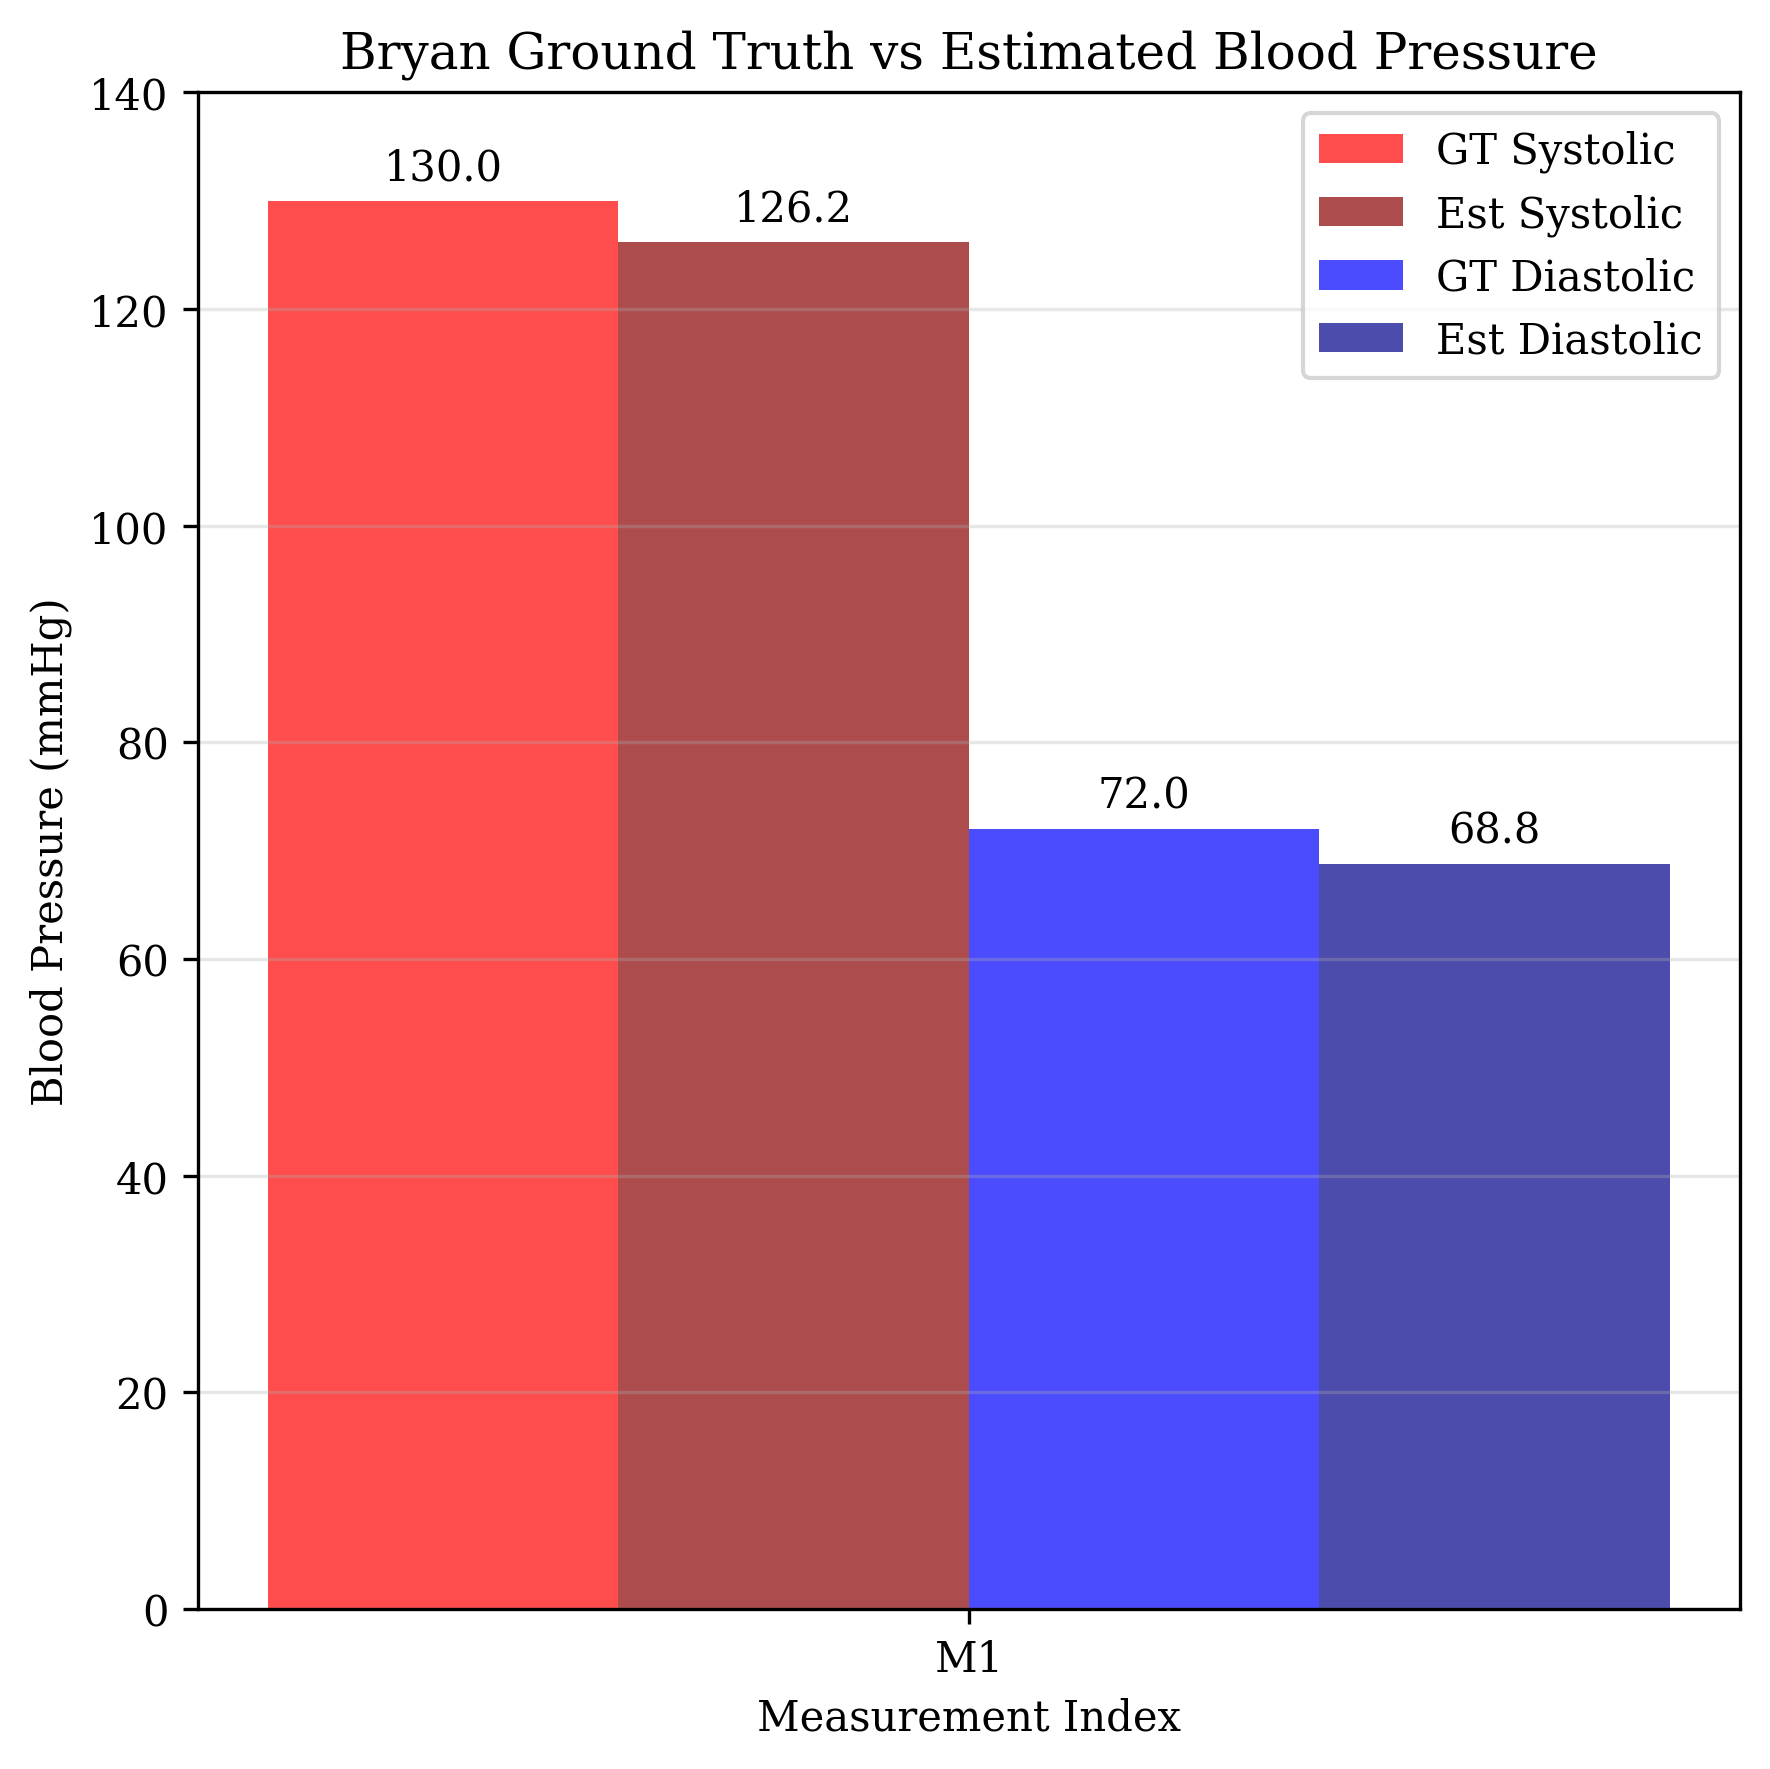

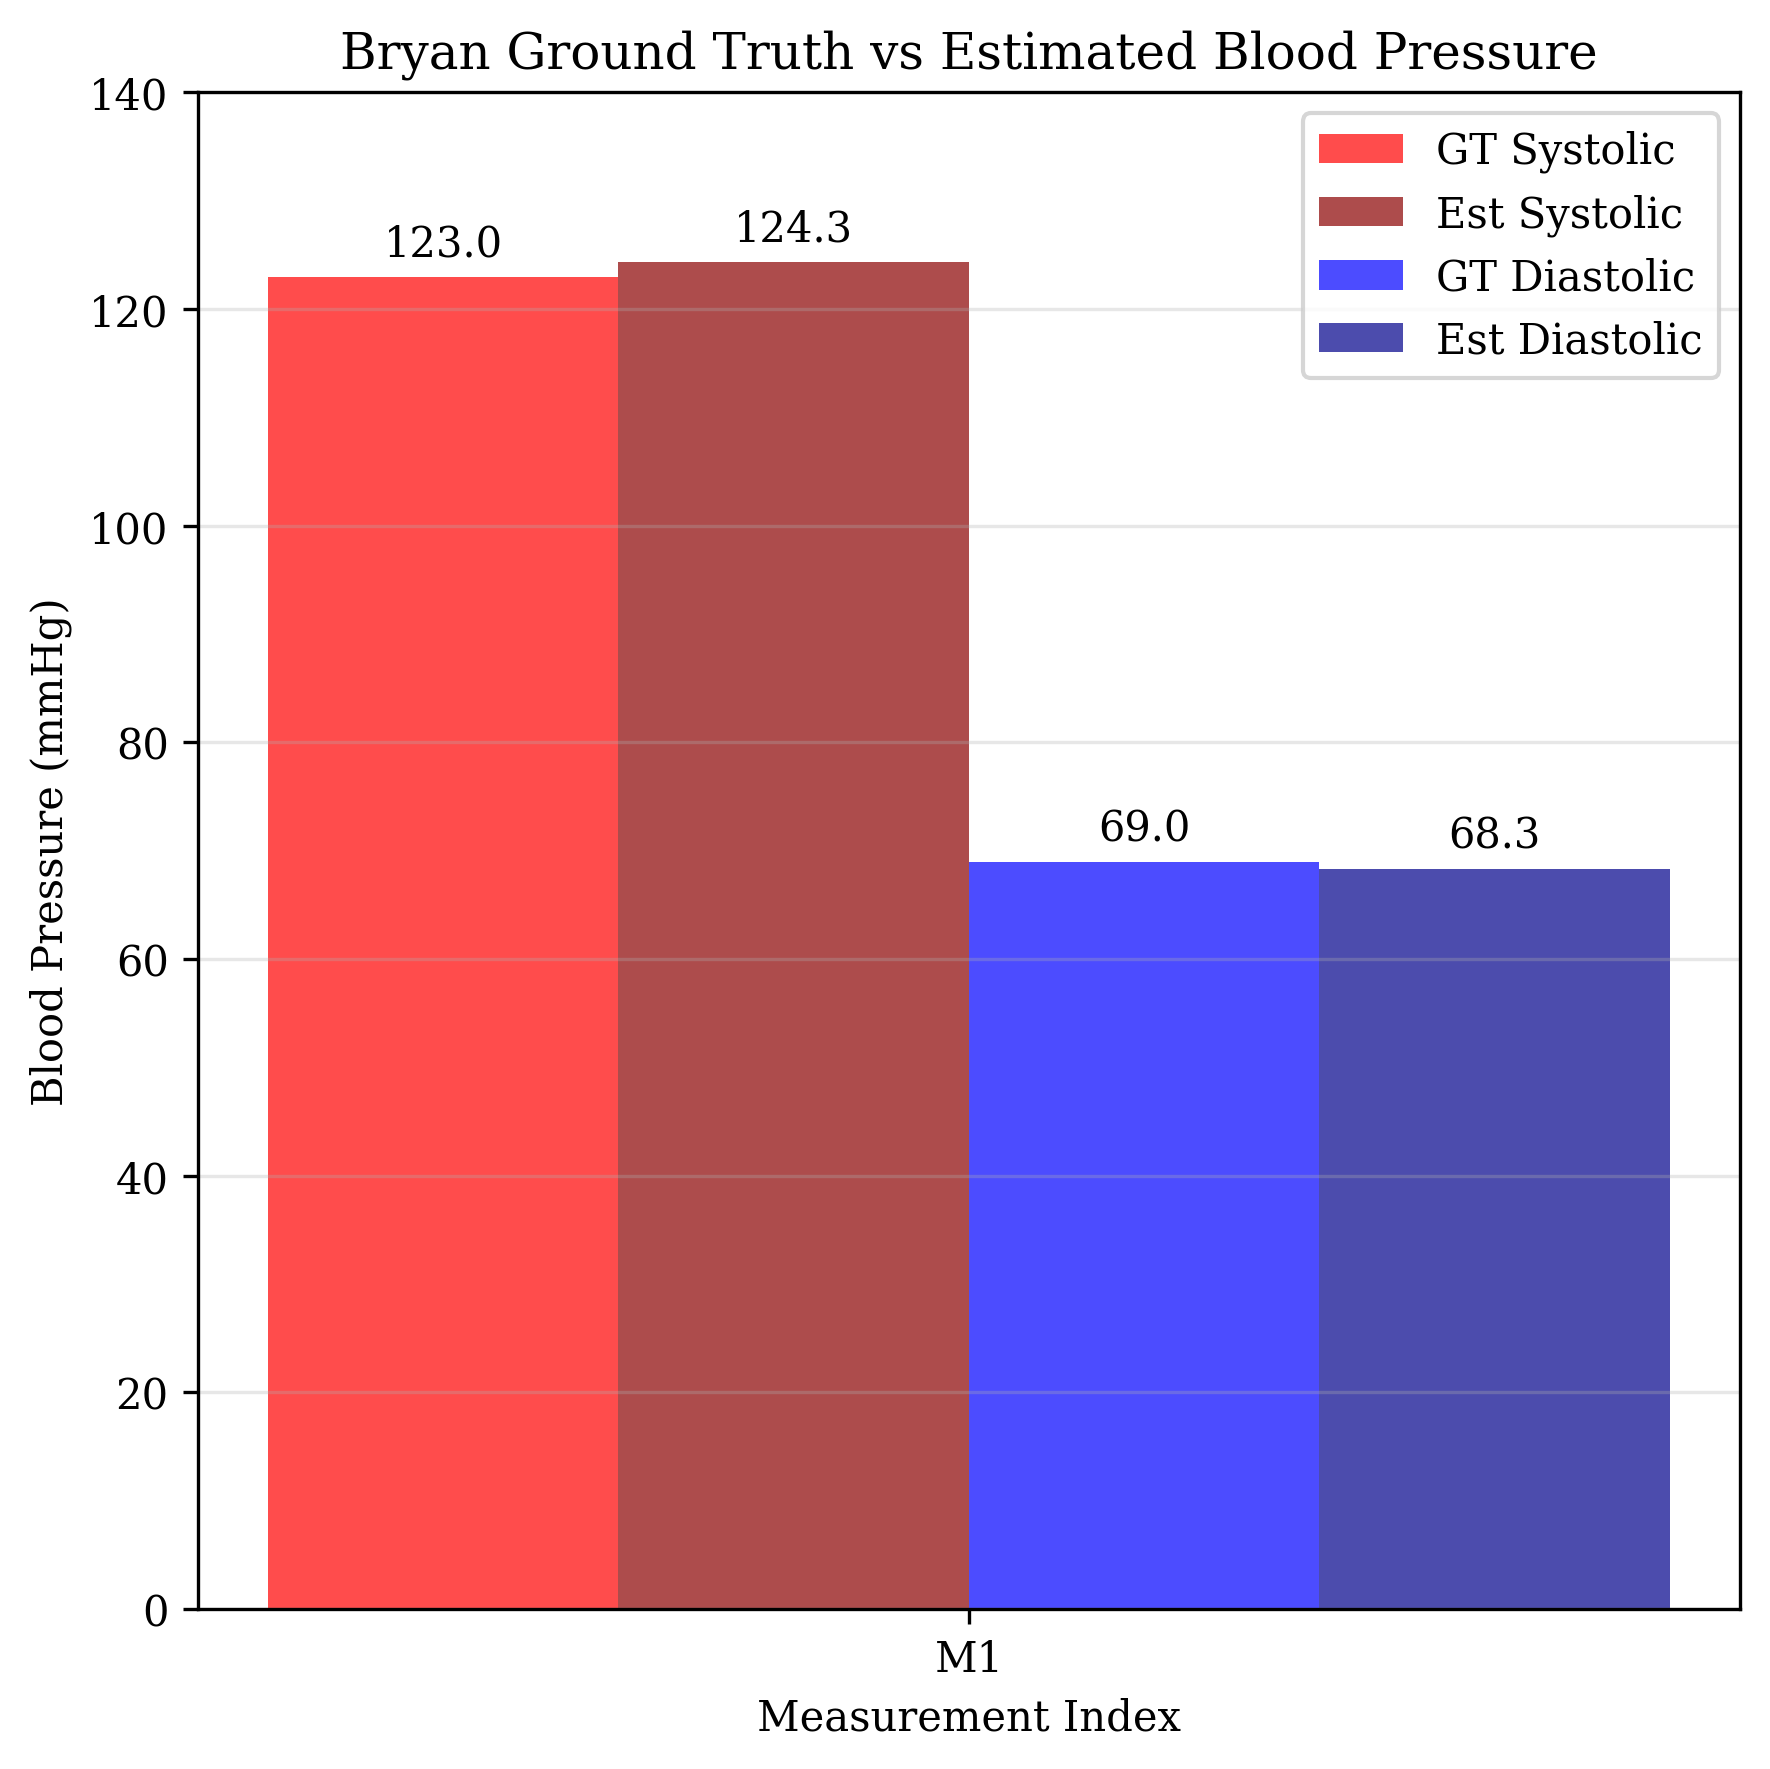

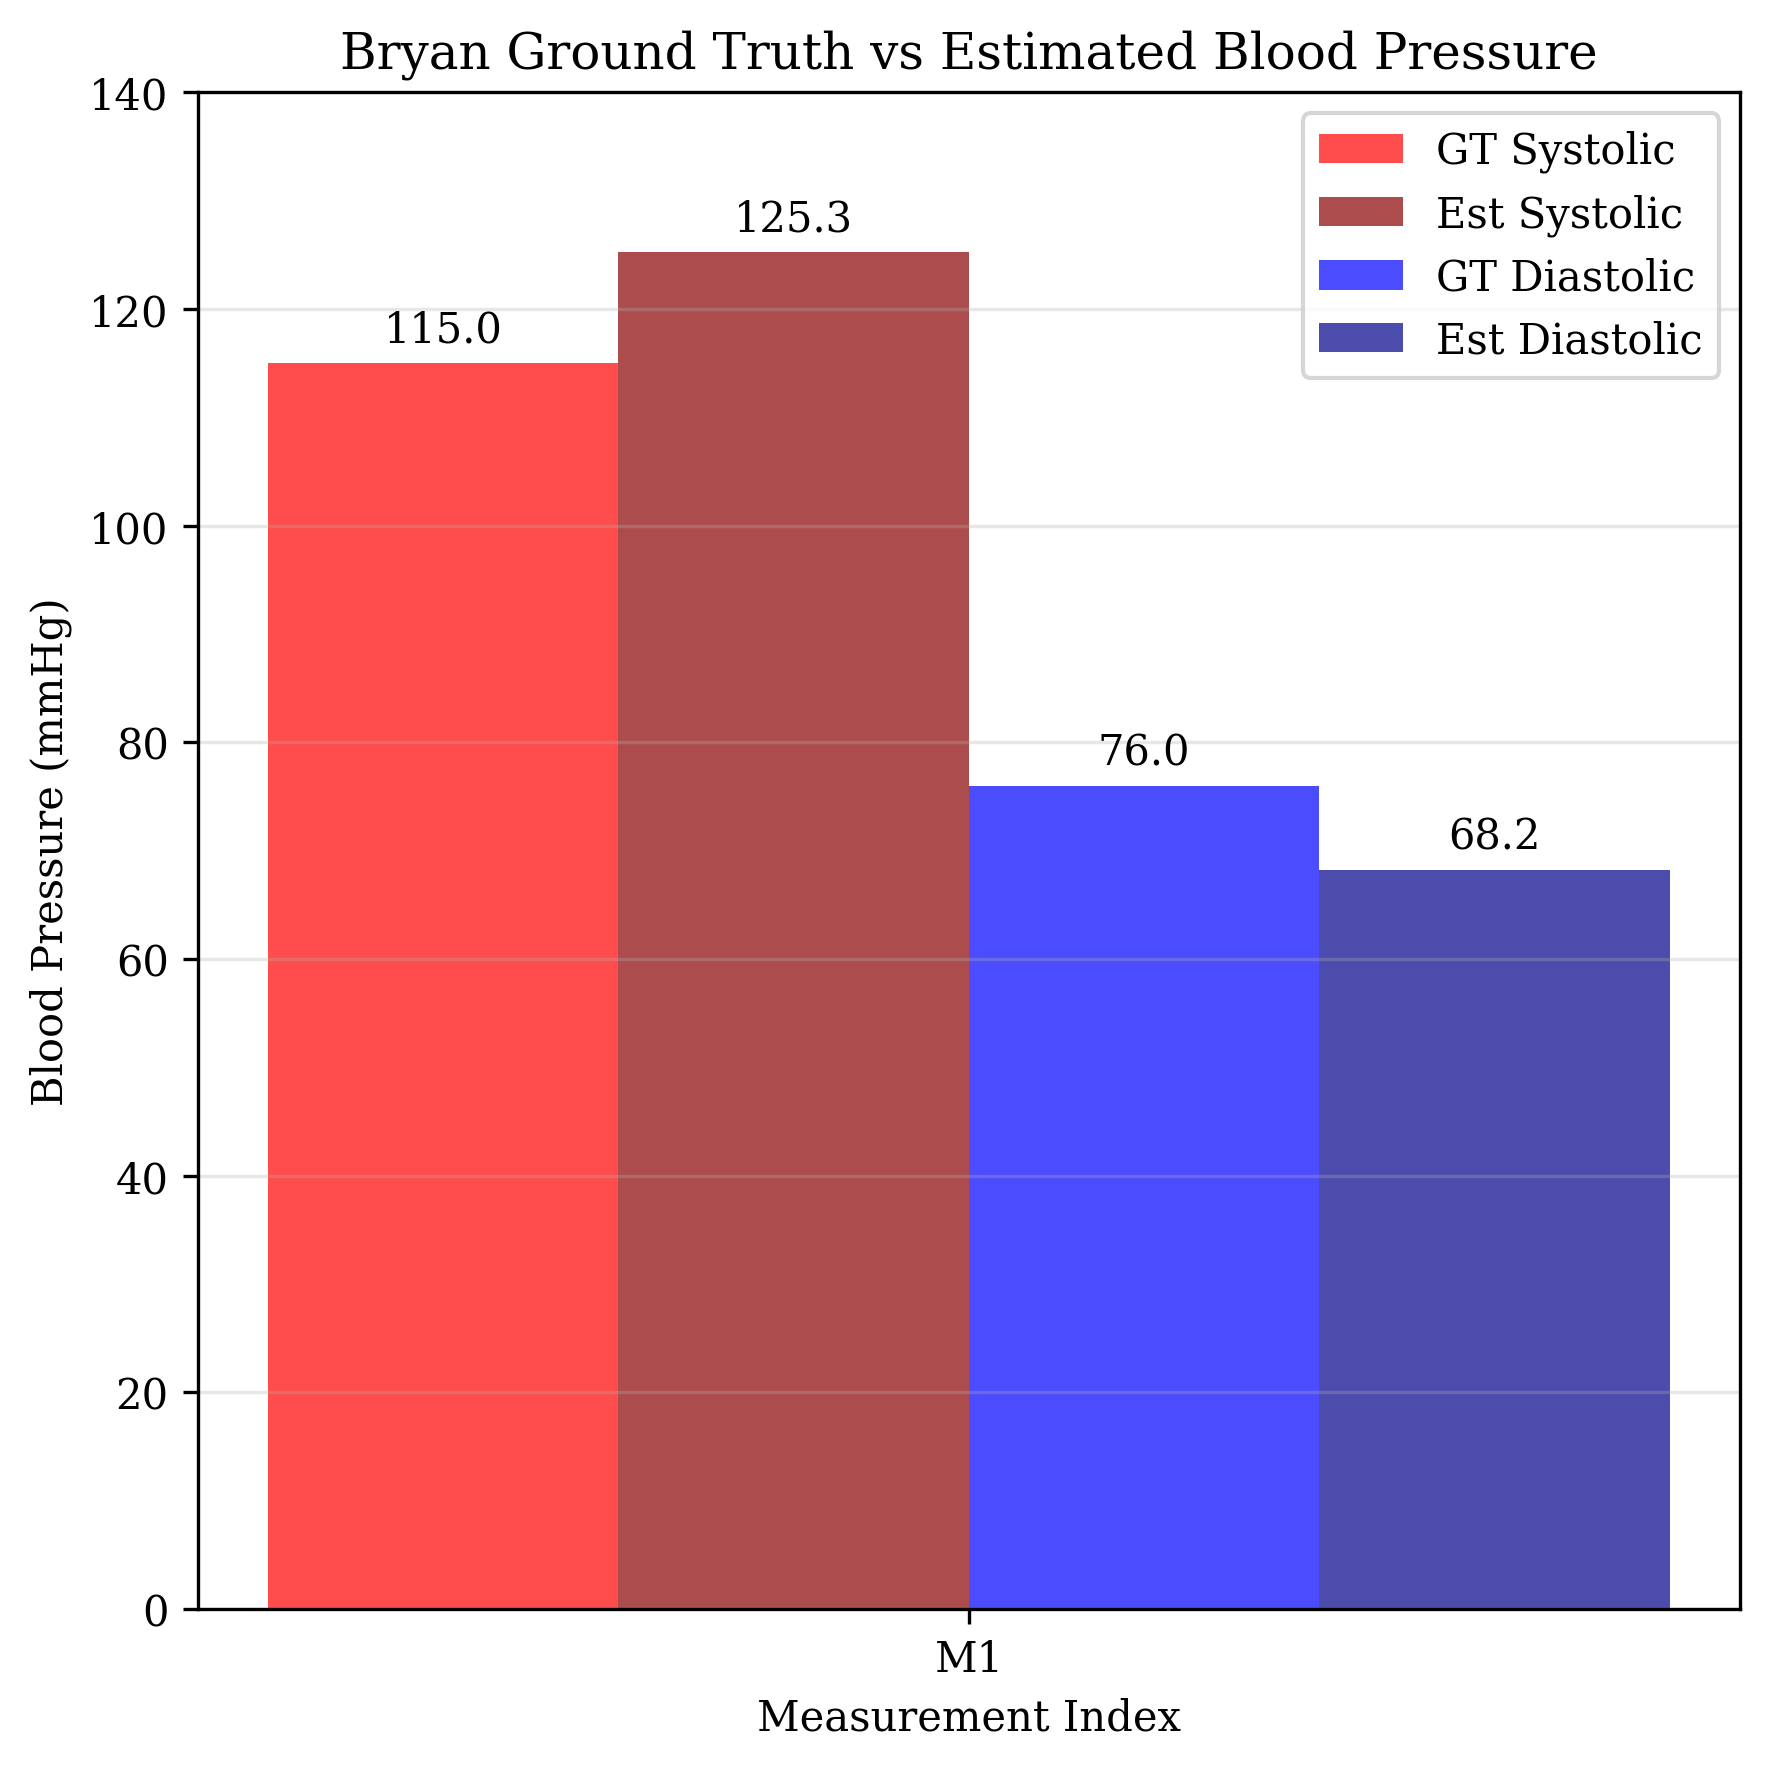

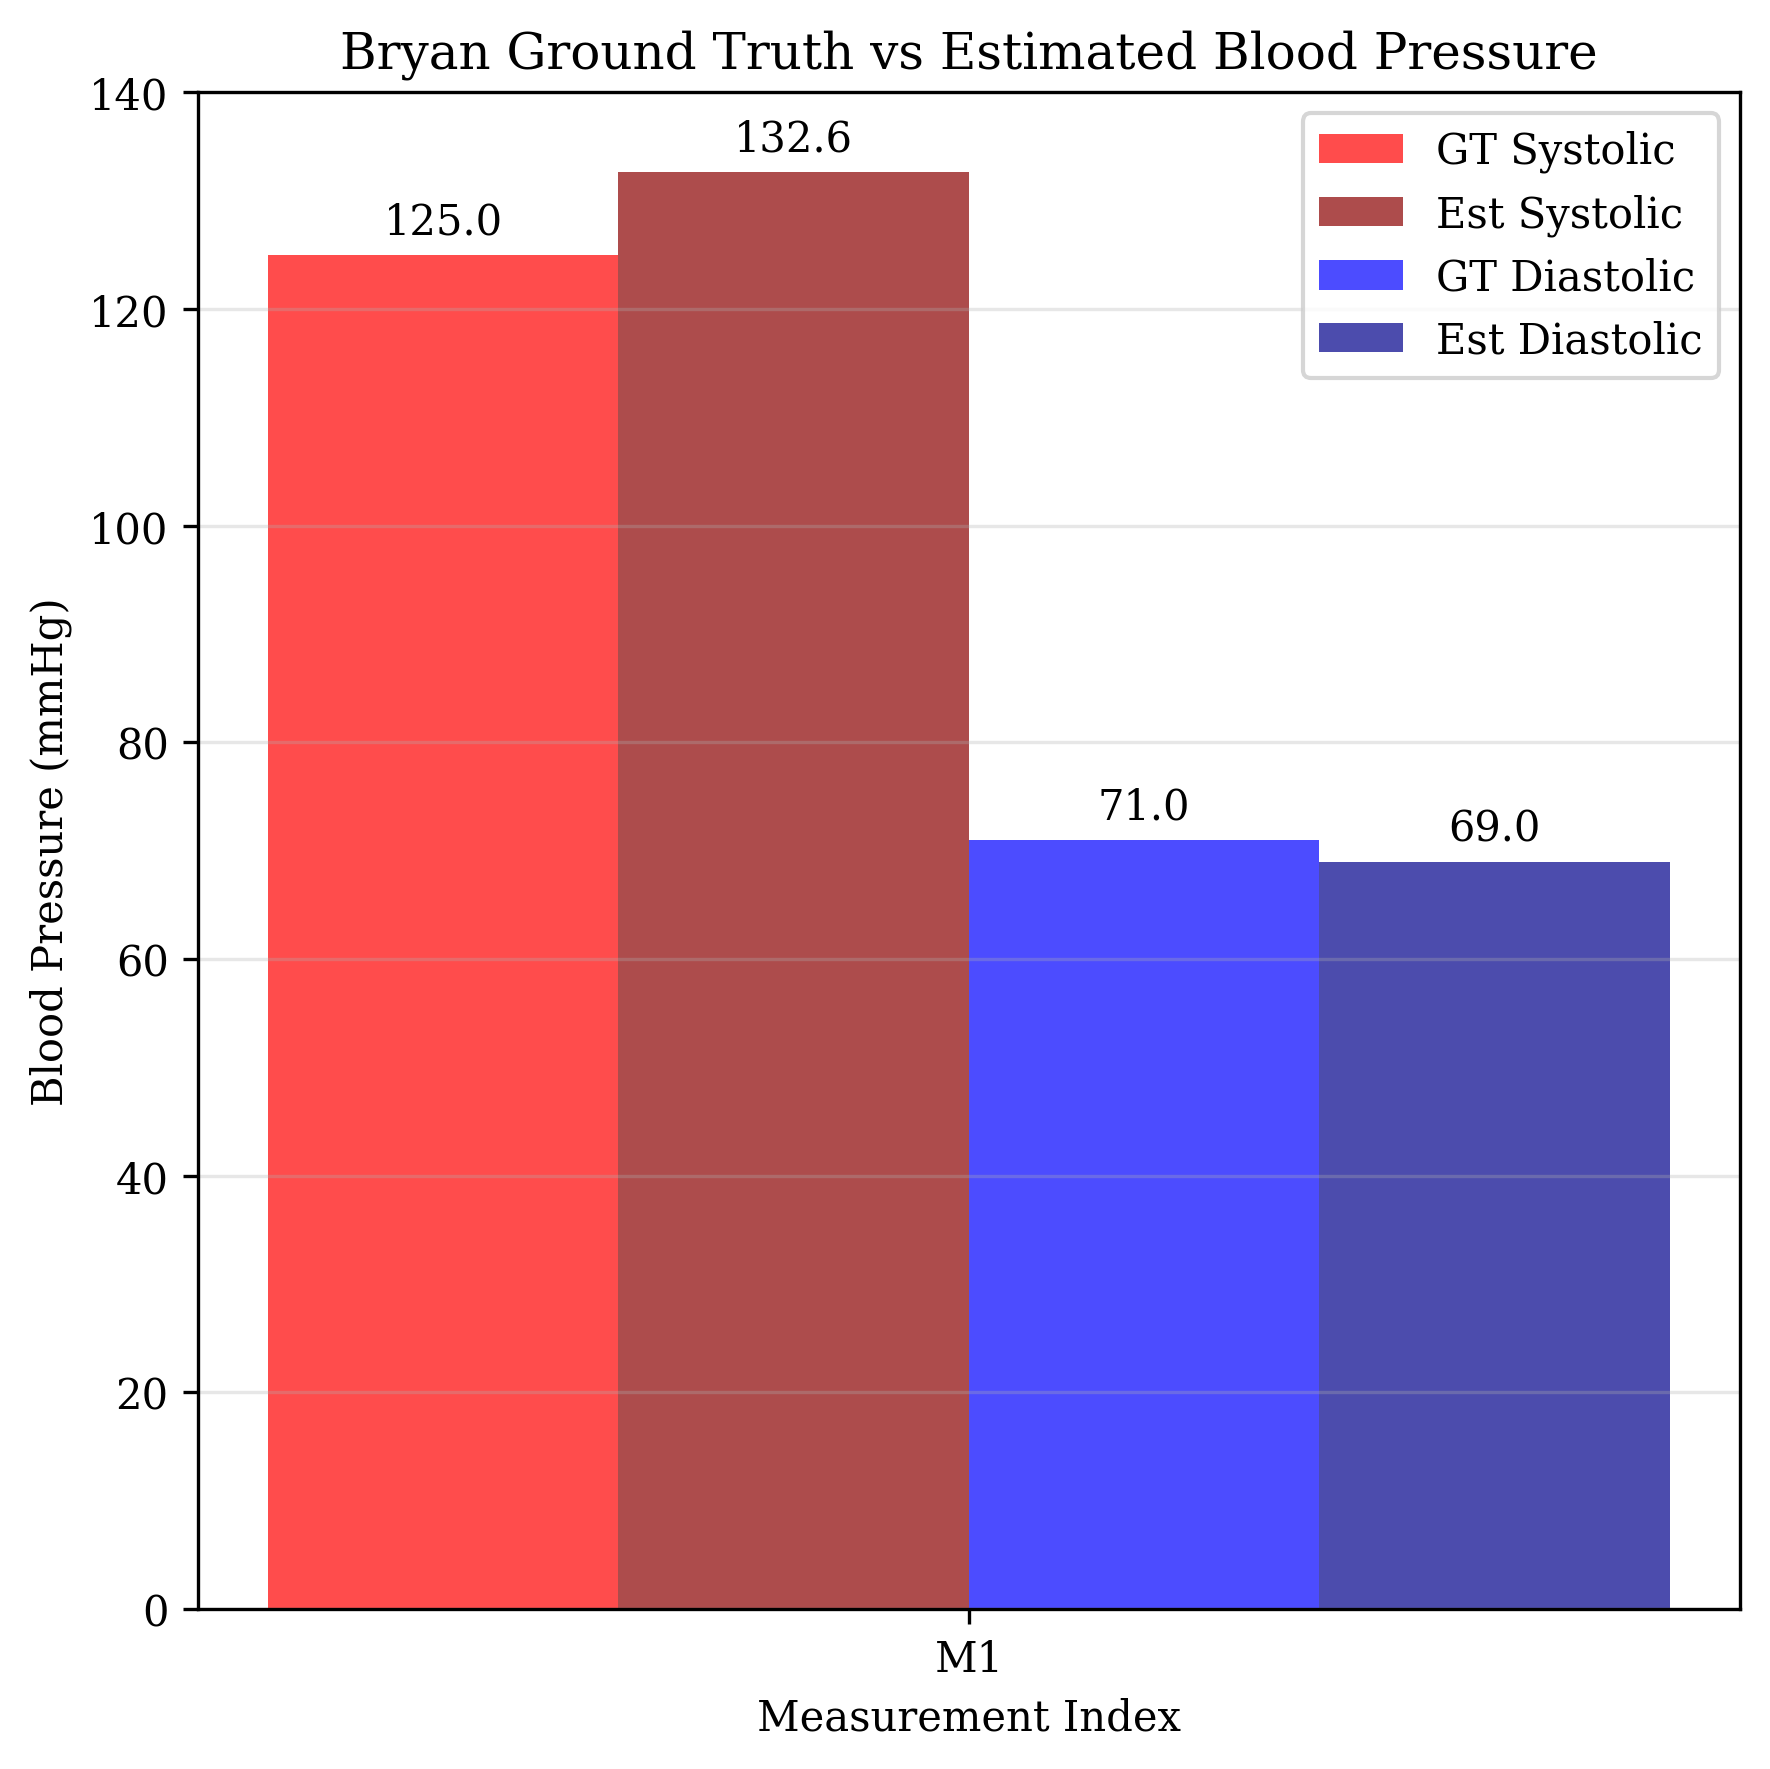

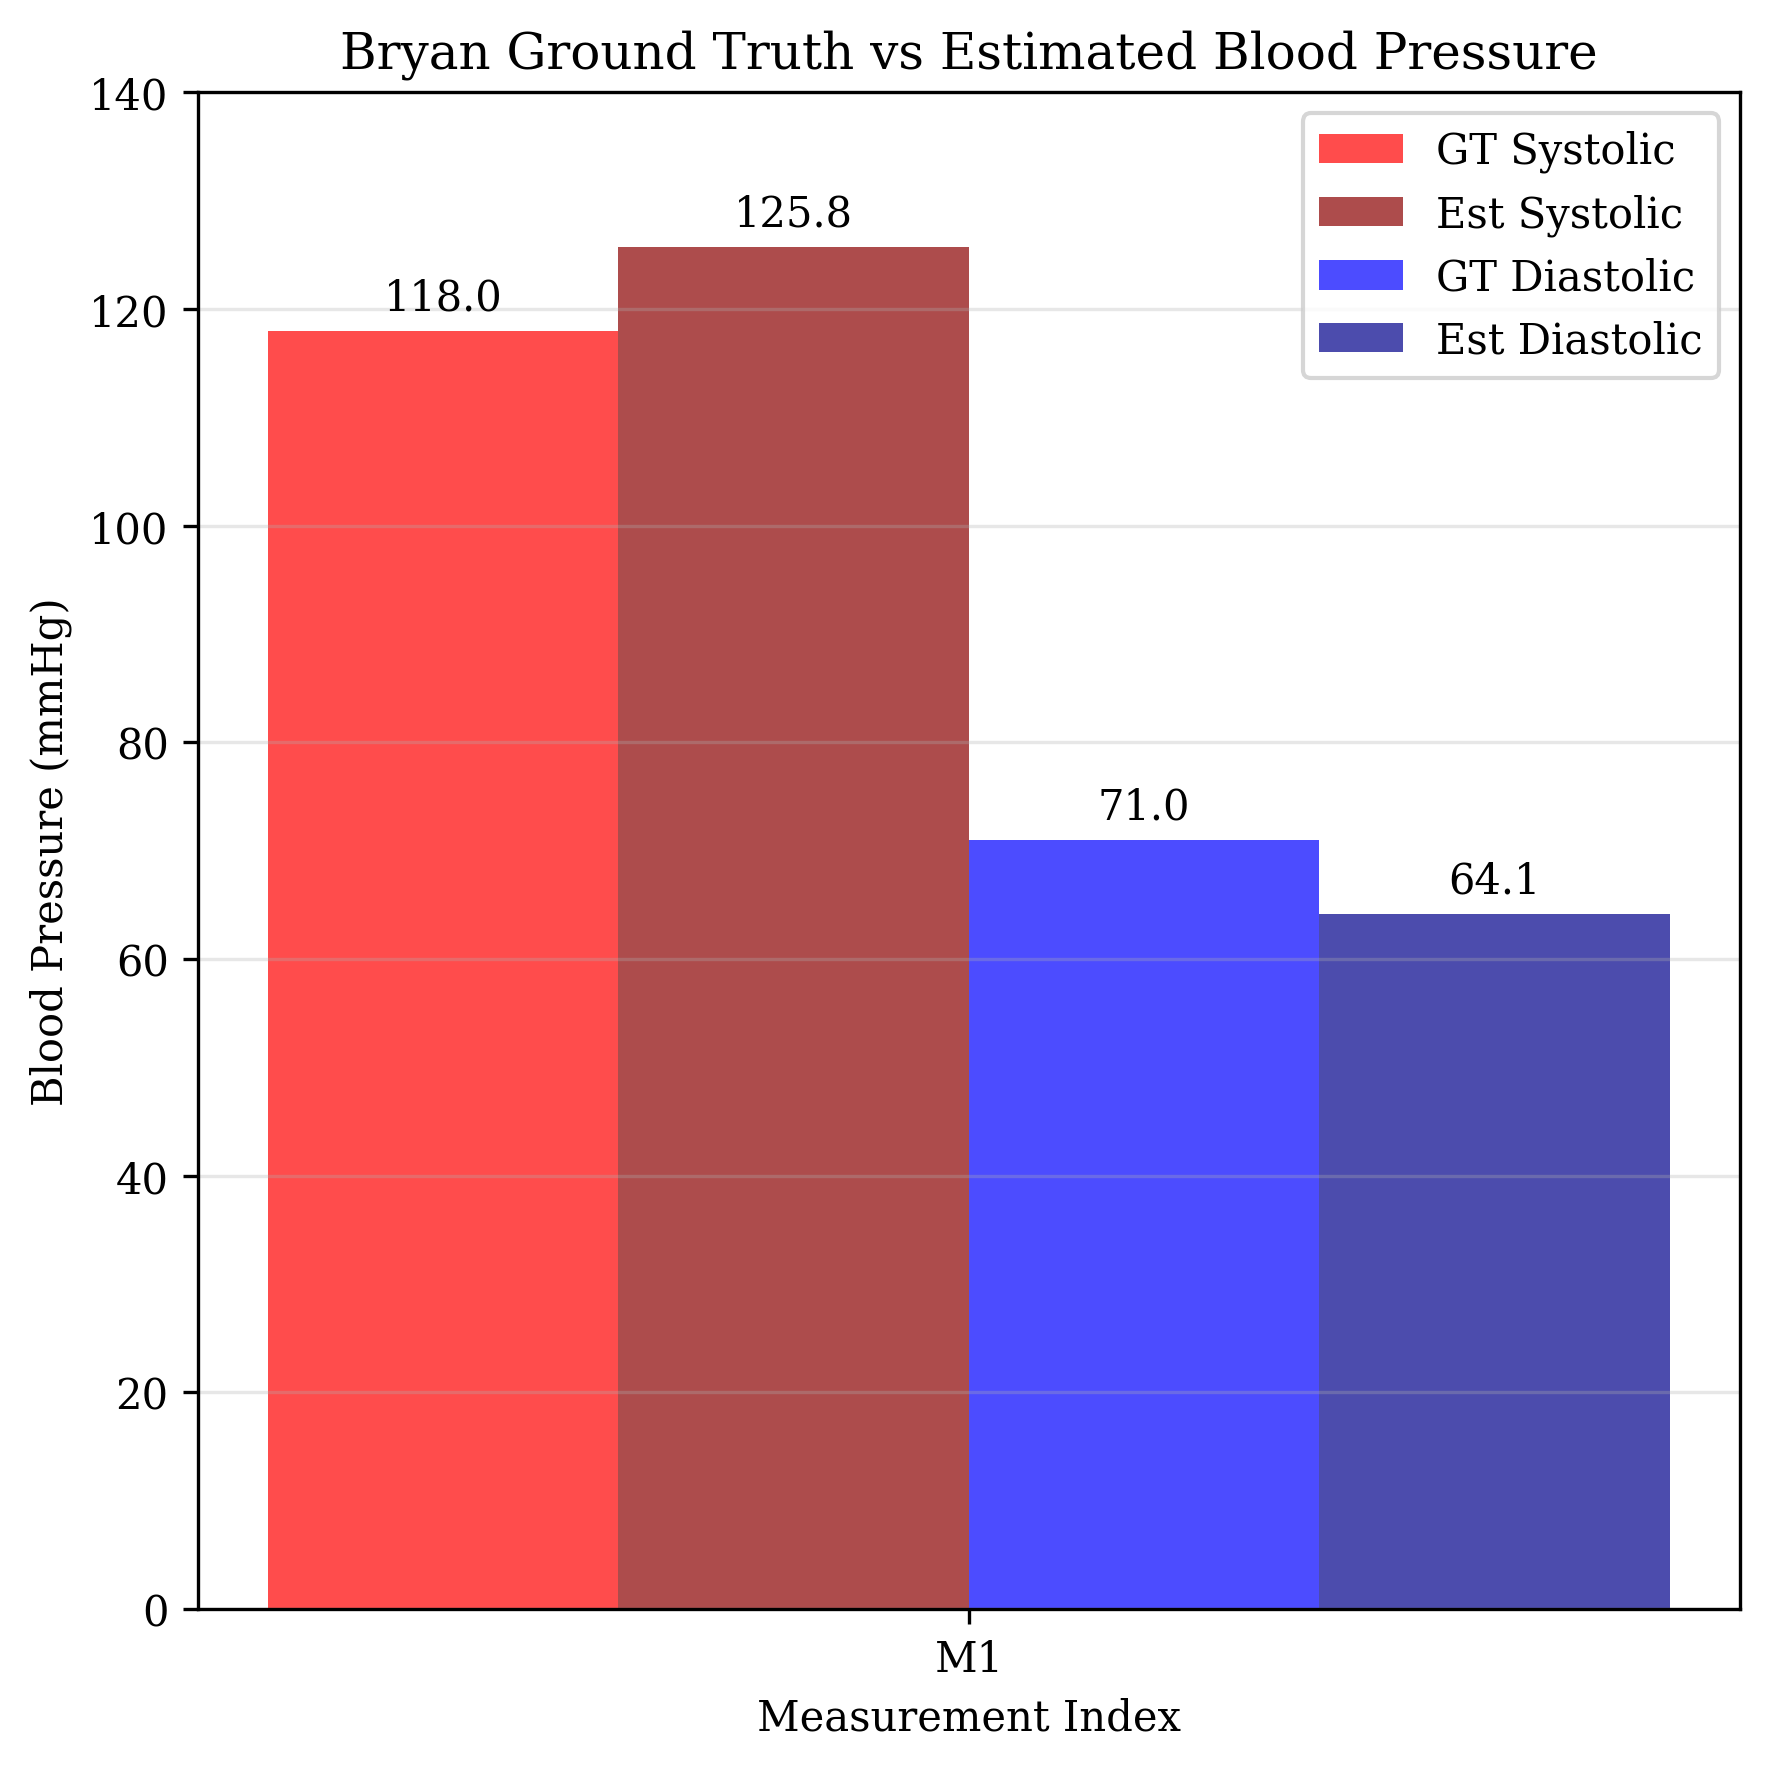

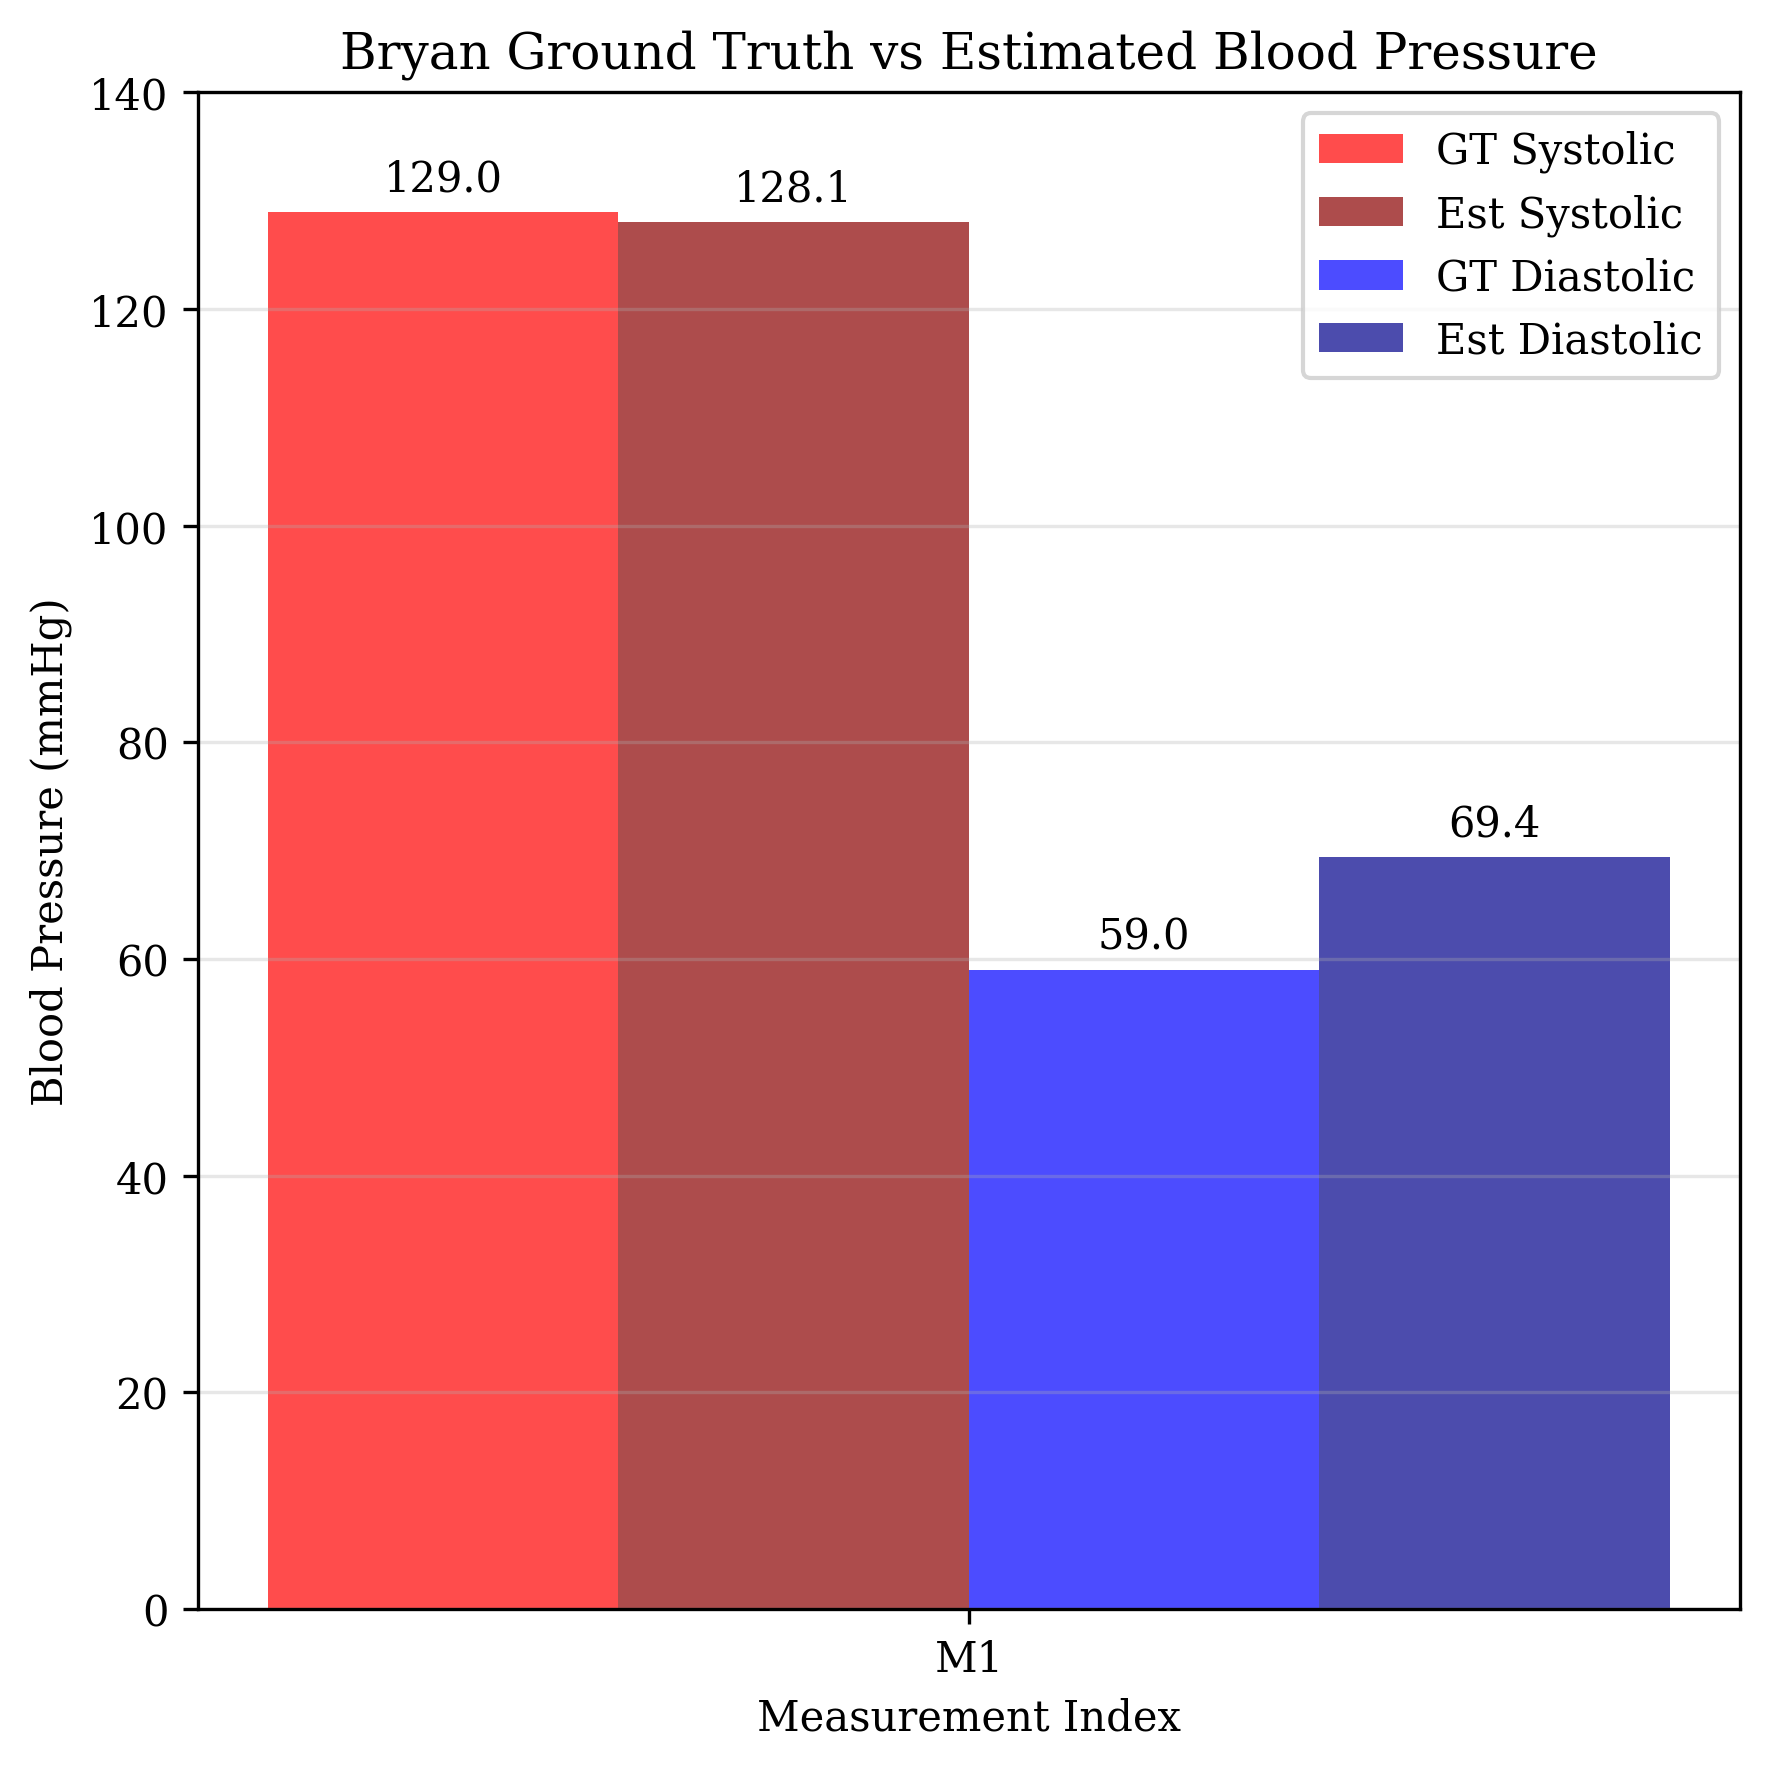

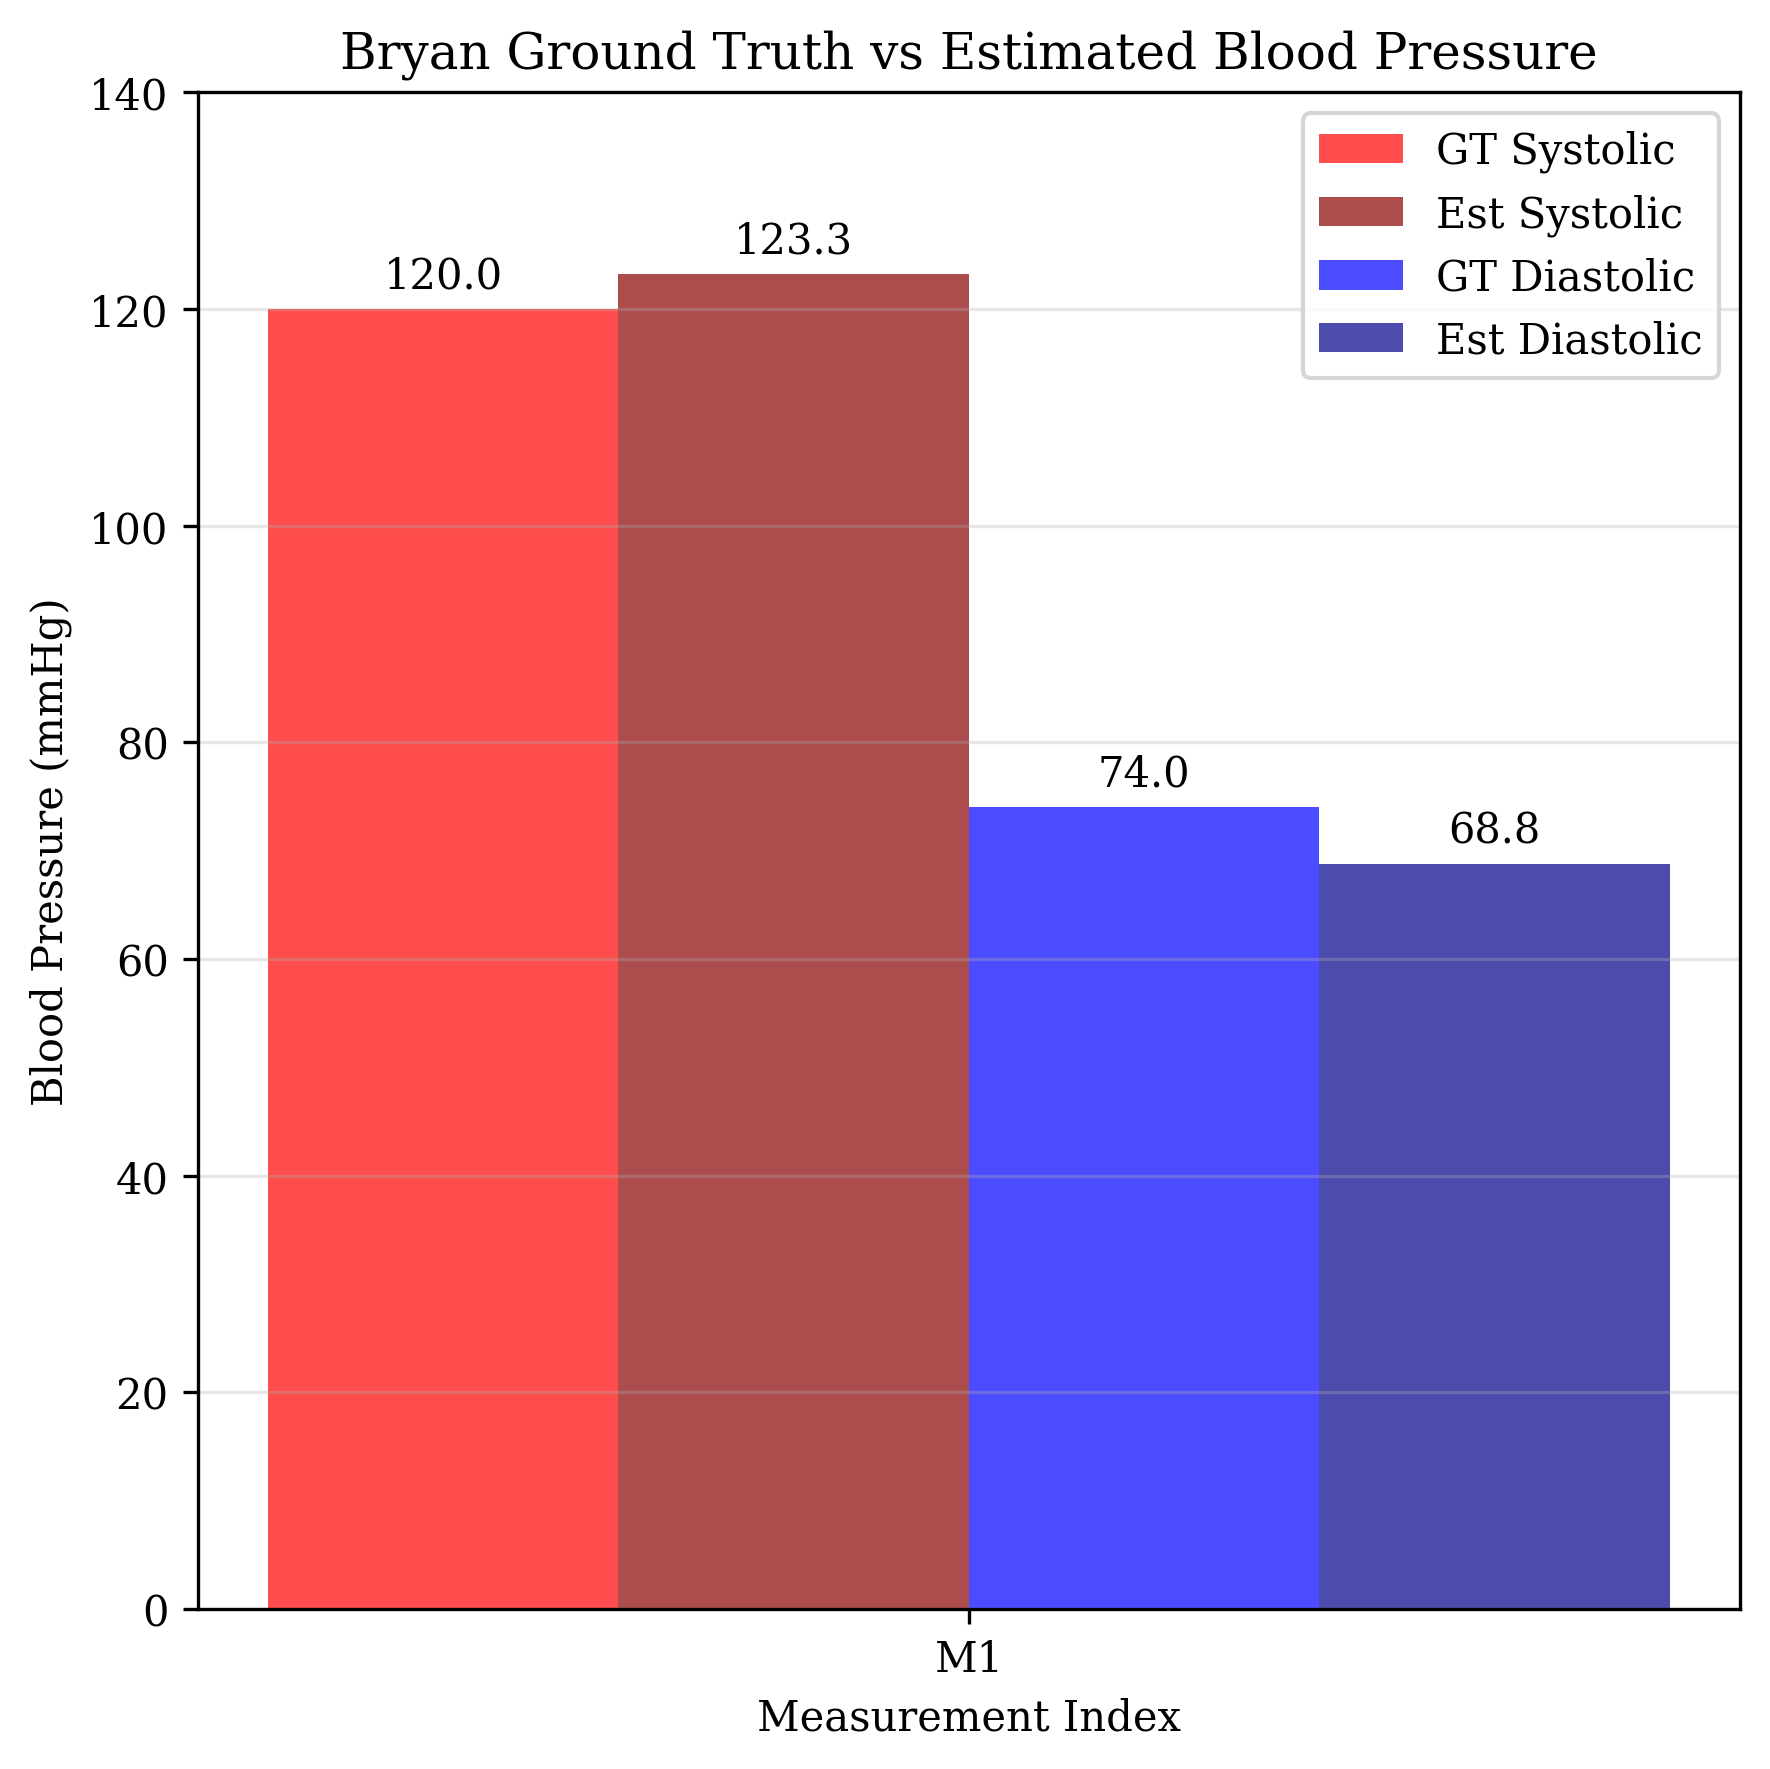

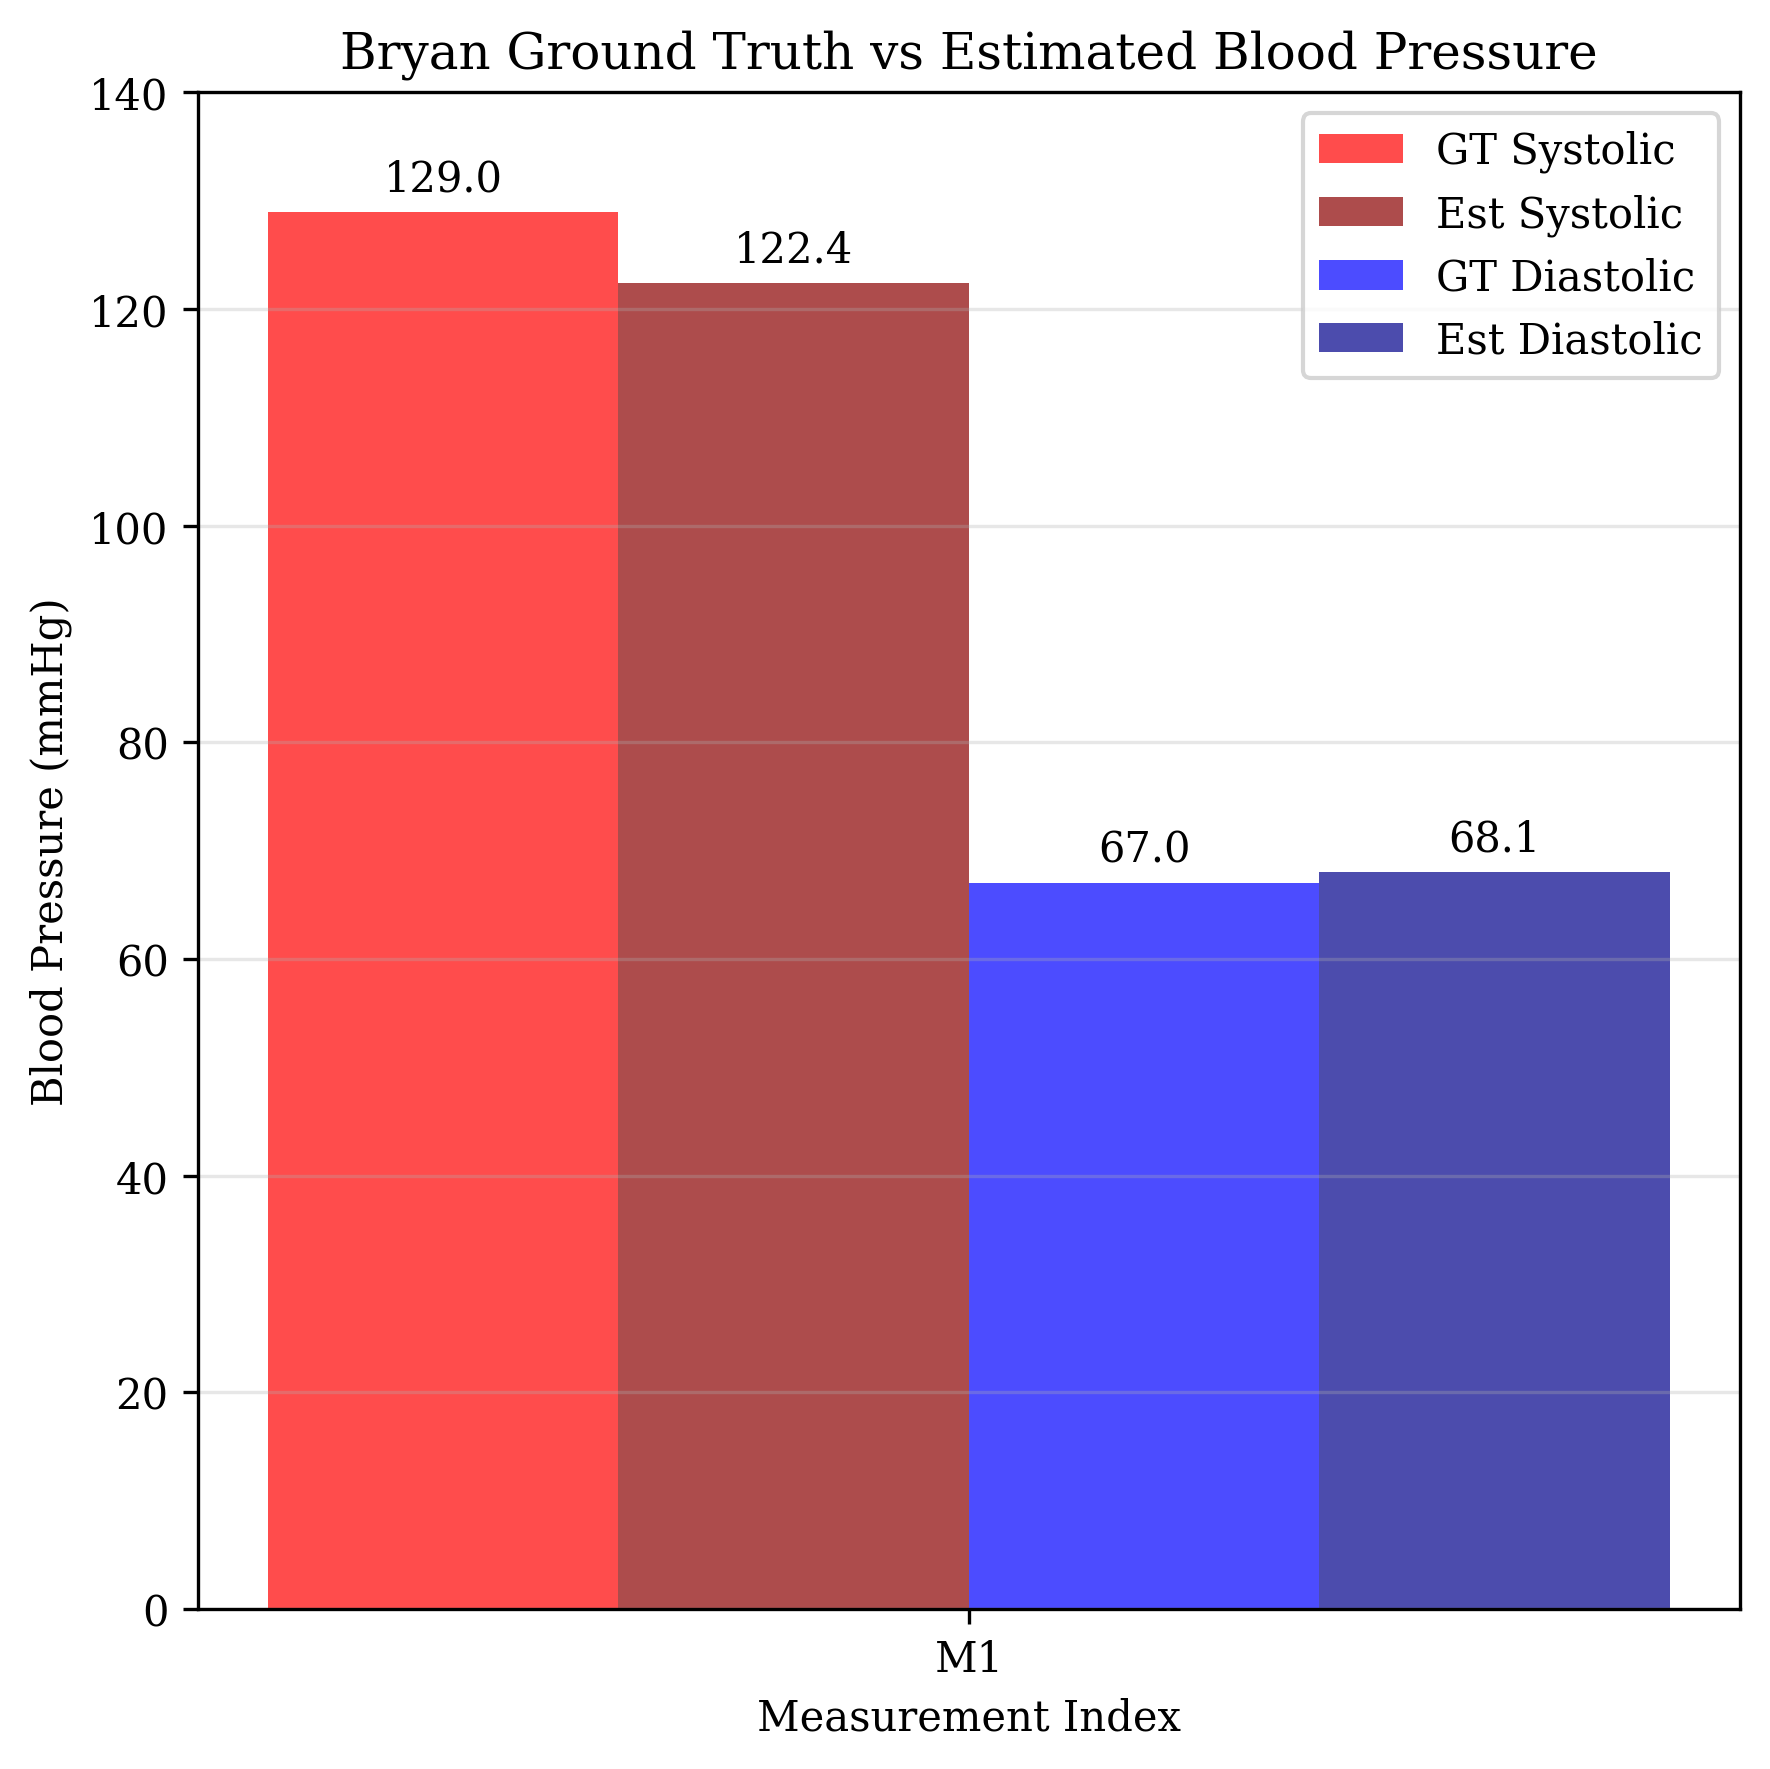

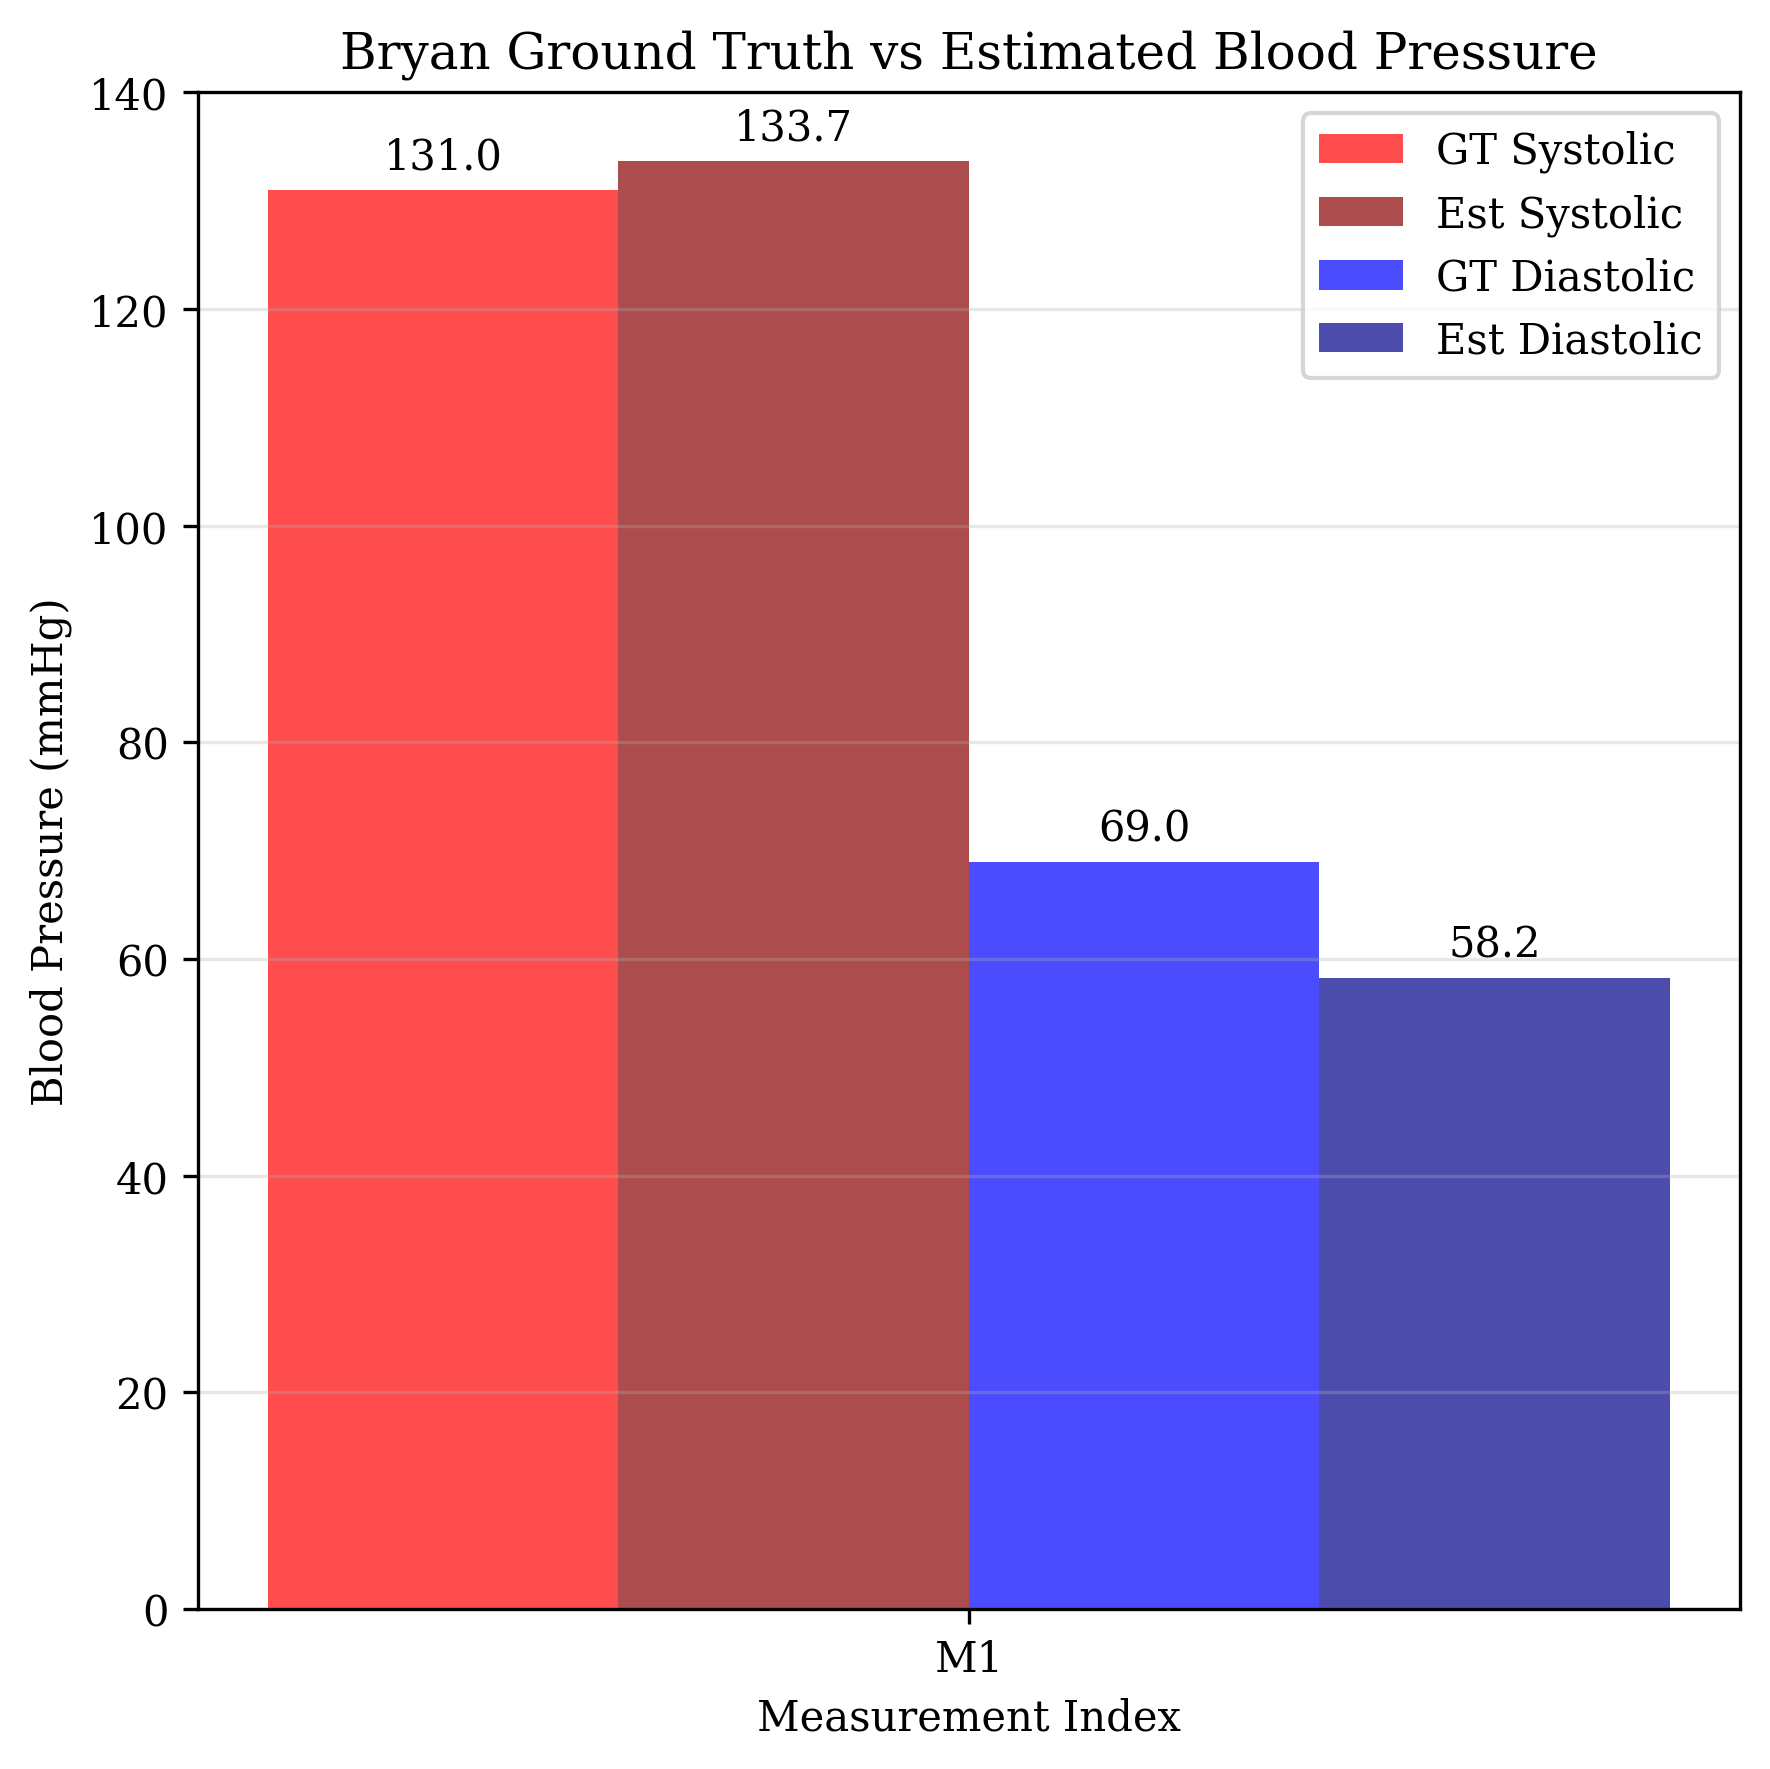

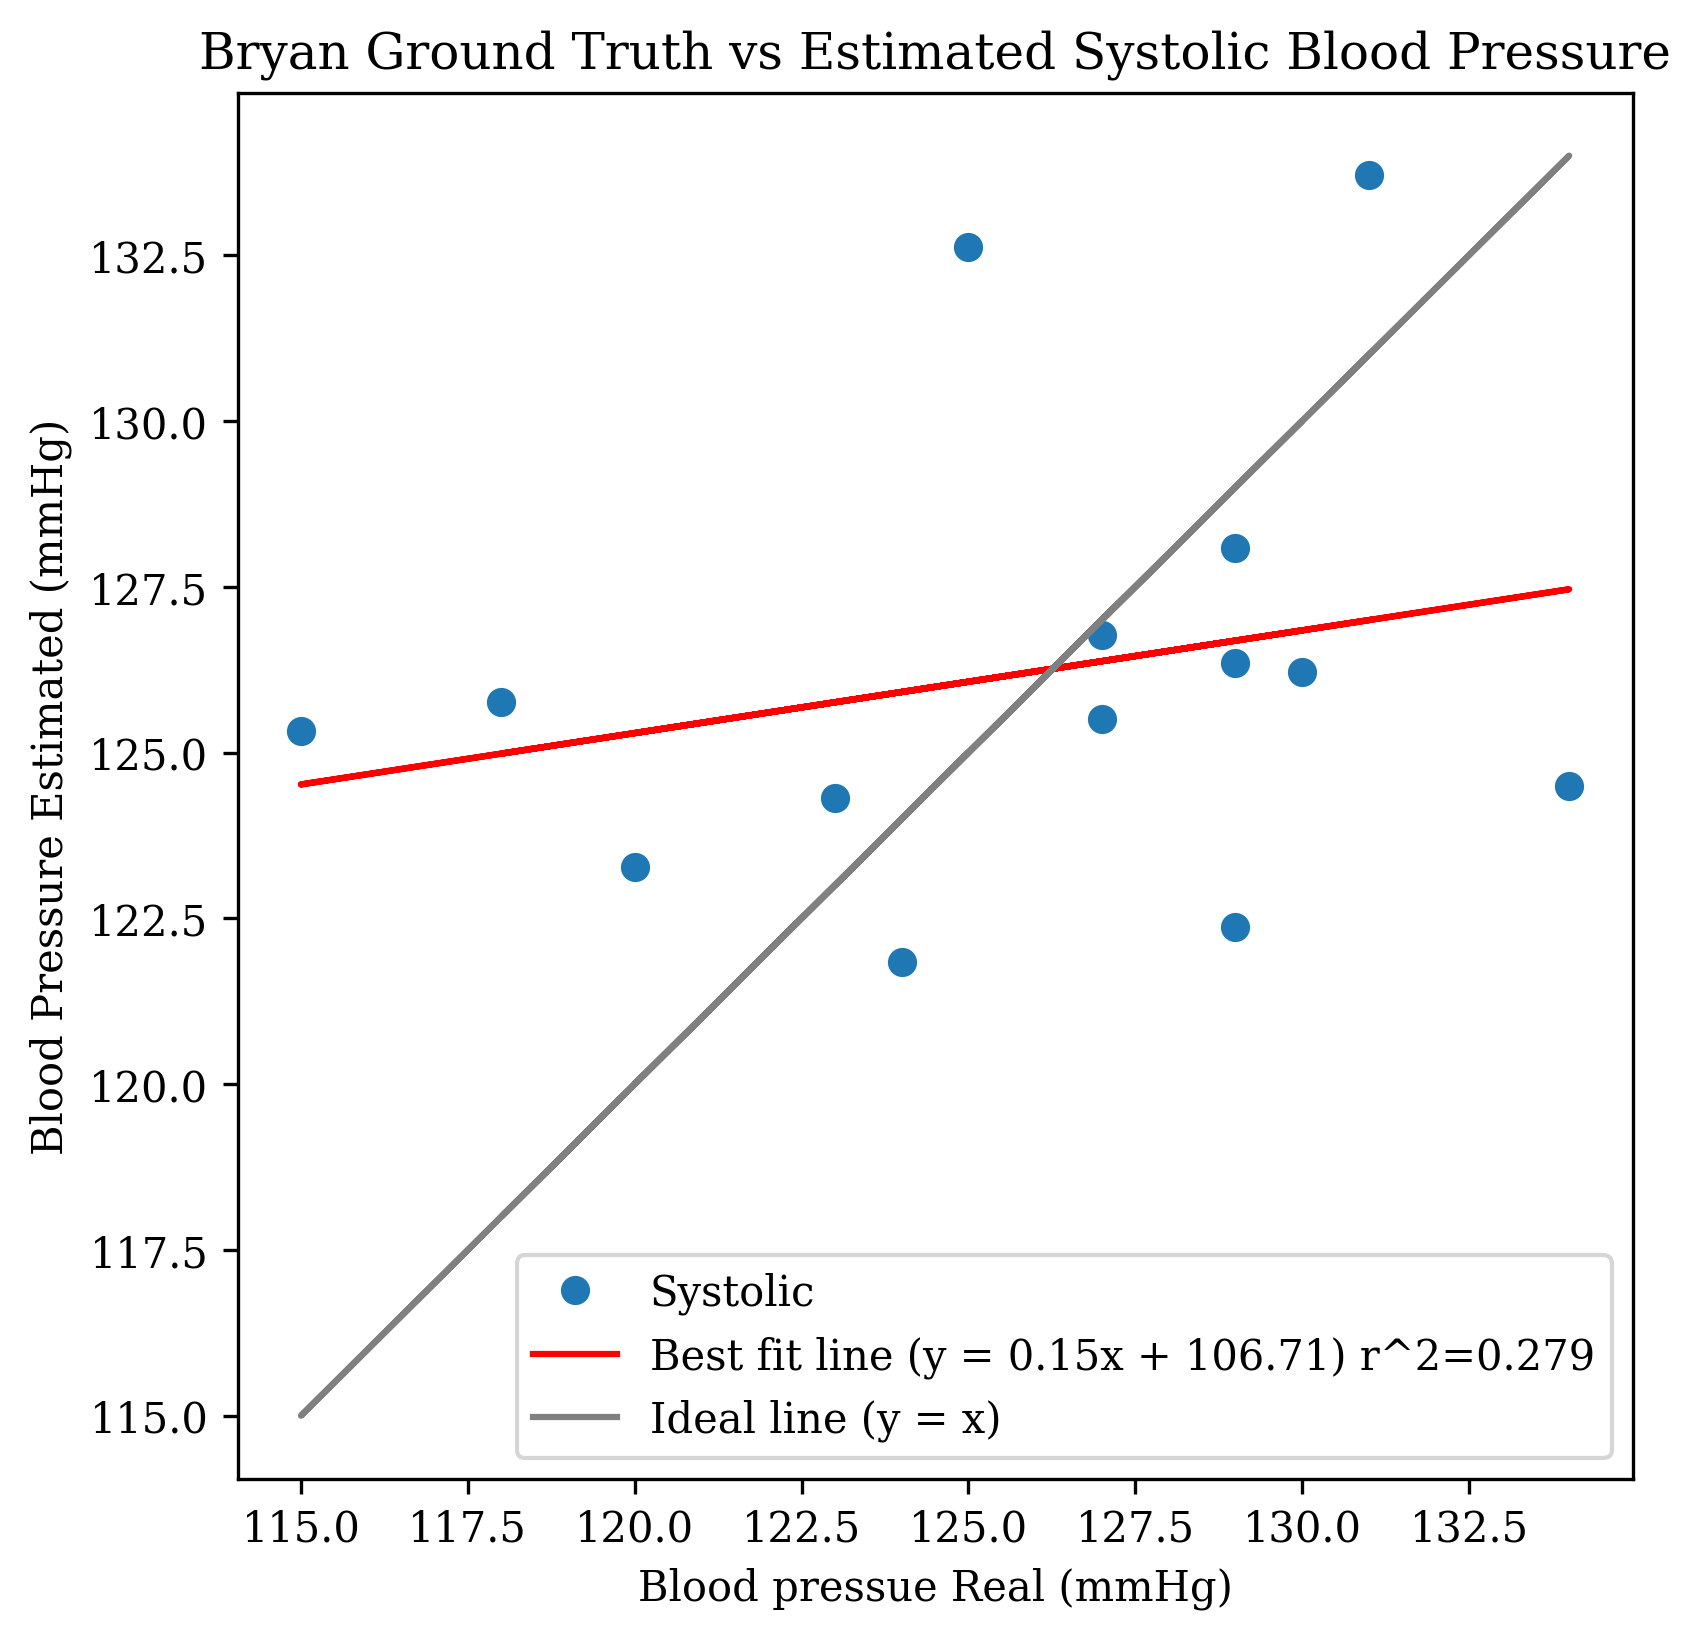

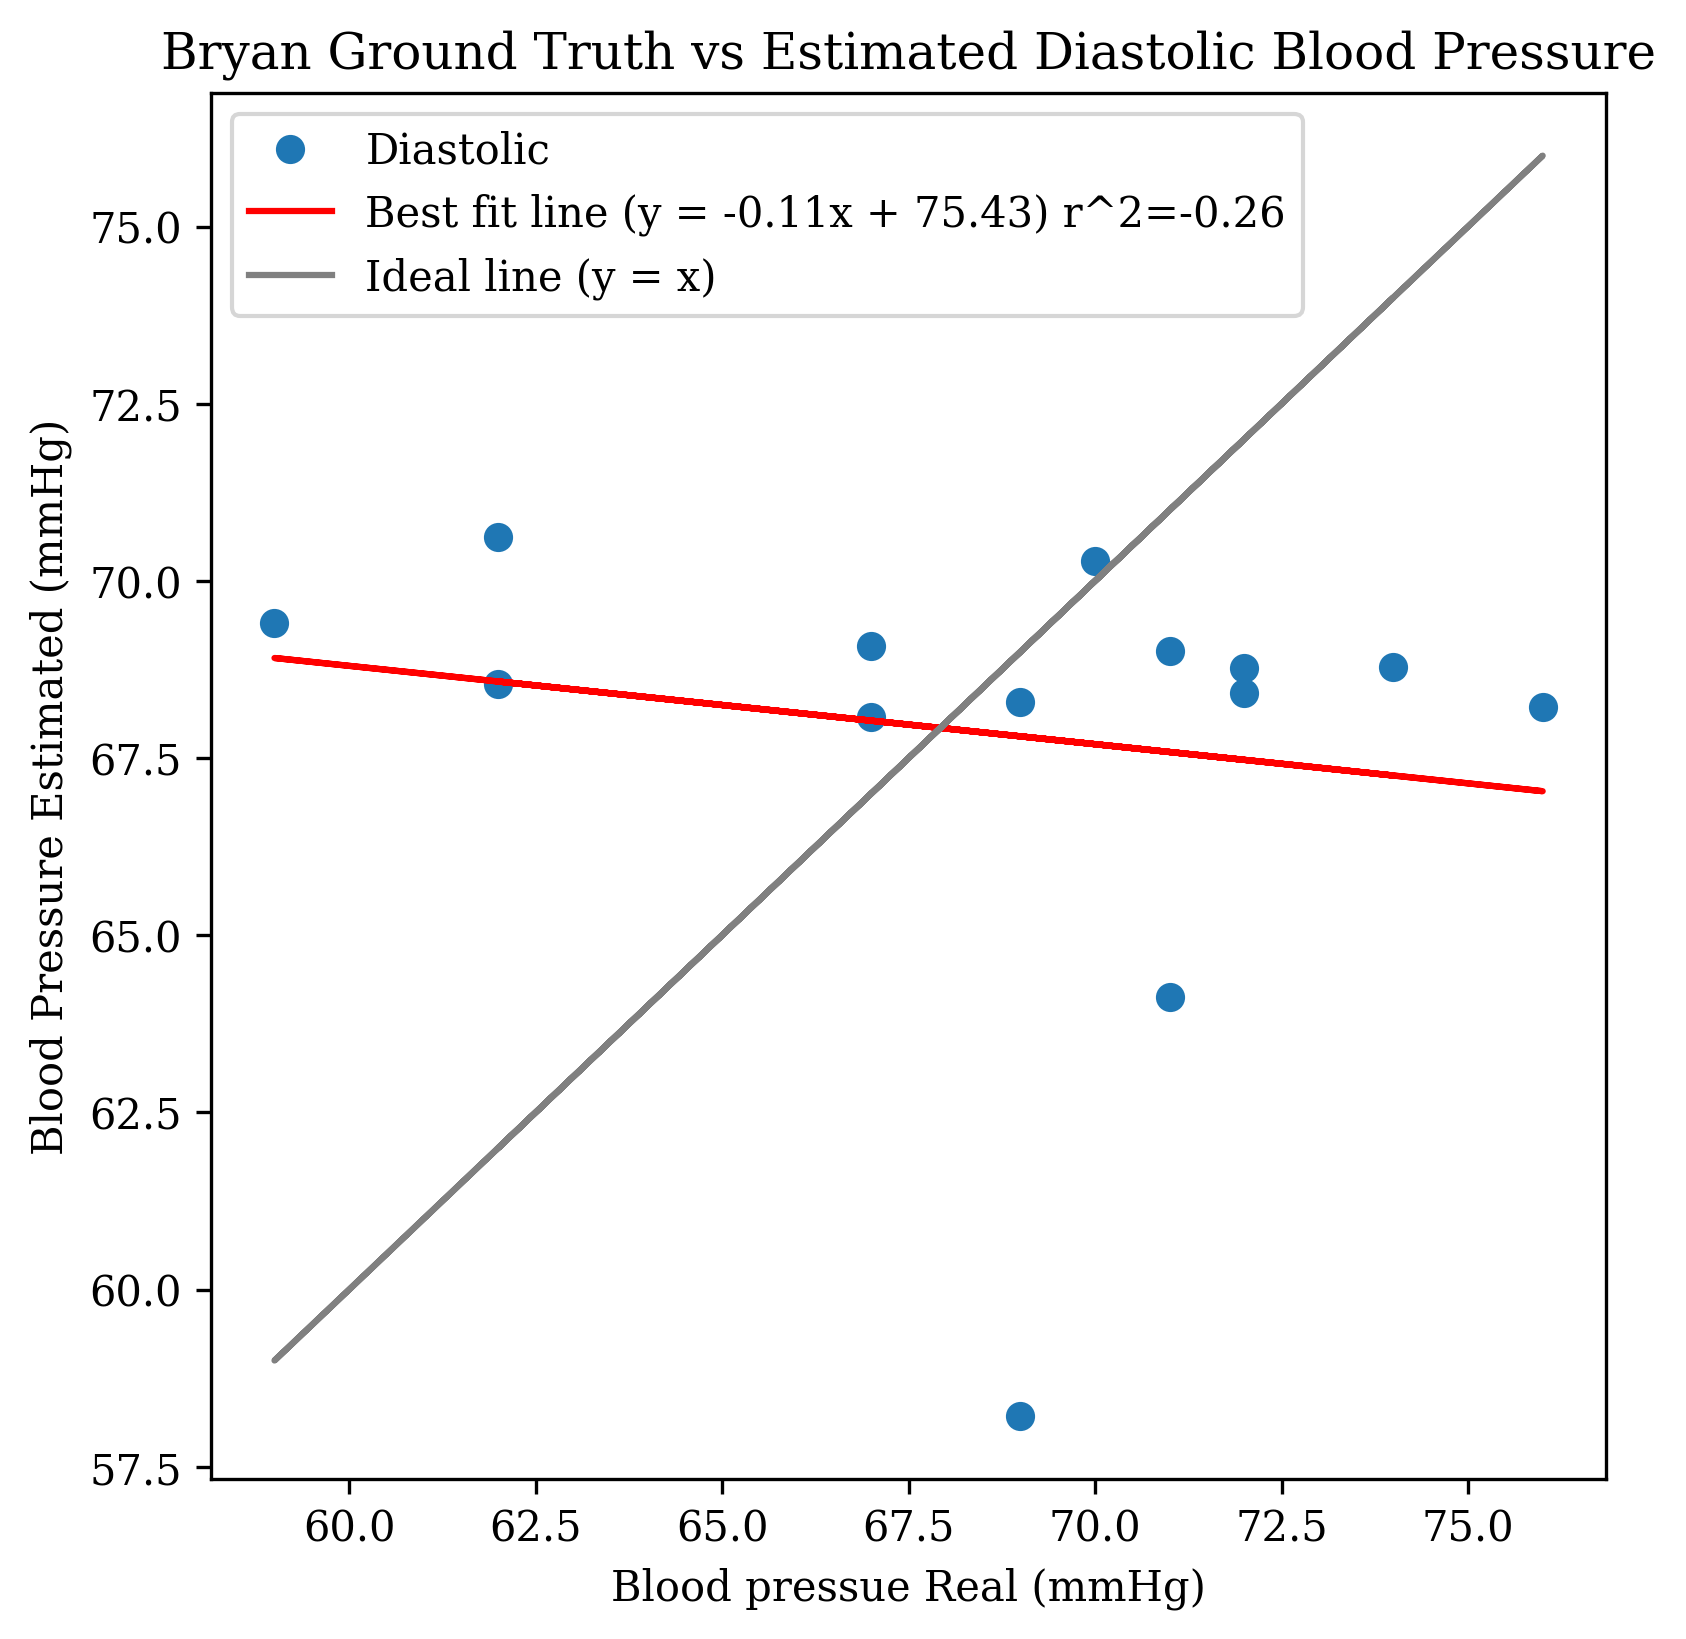

In [6]:
#!/usr/bin/env python3
"""
PPG-based Blood Pressure Model Training Script
Usage: python train_ppg_model.py --person <name> --dir <path>
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import find_peaks
import pickle
from sklearn.linear_model import LinearRegression
import os
import argparse
import json
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional
from sklearn.metrics import r2_score

font = {'family' : 'serif'}

matplotlib.rc('font', **font)

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc('title', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 300
plt.rcParams['svg.fonttype'] = 'none'

@dataclass
class PersonModel:
    """Data class to store person-specific model parameters"""

    name: str
    baseline_hr: float
    baseline_mnpv: float
    baseline_sbp: float
    baseline_dbp: float
    baseline_map: float
    sbp_coeffs: Tuple[float, float, float]  # (a, b, c)
    dbp_coeffs: Tuple[float, float, float]
    map_coeffs: Tuple[float, float, float]
    r2_scores: Dict[str, float]  # R² scores for each model


class PPGBloodPressureModel:
    def __init__(self, person_name: str, data_dir: str):
        self.person_name = person_name
        self.data_dir = data_dir
        self.baseline_file = os.path.join(data_dir, f"{person_name.lower()}_baseline.csv")
        self.model_file = os.path.join(data_dir, f"{person_name}_model.pkl")

        # Model parameters
        self.baseline_hr = None
        self.baseline_mnpv = None
        self.baseline_sbp = None
        self.baseline_dbp = None
        self.baseline_map = None

        # Regression models
        self.sbp_model = LinearRegression()
        self.dbp_model = LinearRegression()
        self.map_model = LinearRegression()

    def load_ppg_data(self, file_path: str) -> np.ndarray:
        """Load PPG data from CSV file"""
        time_vals = []
        signal_vals = []
        ground_truth = None

        with open(file_path, "r") as f:
            for i, line in enumerate(f):
                parts = line.strip().split(",")
                if len(parts) < 2:
                    continue

                # First line contains ground truth values
                if i == 0 and len(parts) >= 5:
                    try:
                        _, _, sbp, dbp, hr = parts[:5]
                        ground_truth = {
                            "sbp": float(sbp),
                            "dbp": float(dbp),
                            "hr": float(hr),
                        }
                    except (ValueError, IndexError):
                        pass

                try:
                    t = float(parts[0])
                    s = float(parts[1])
                    time_vals.append(t * 1e-3)  # convert ms to s
                    signal_vals.append(s)
                except ValueError:
                    continue

        data = np.column_stack((time_vals, signal_vals))
        return data, ground_truth

    def calculate_ppg_features(self, time: np.ndarray, signal: np.ndarray) -> Dict:
        """Calculate PPG features from time and signal arrays"""
        # Sampling frequency
        fs = 1.0 / np.mean(np.diff(time))

        # DC level
        dc = np.mean(signal)

        # Find peaks and troughs
        peaks, _ = find_peaks(signal, prominence=4, distance=fs * 0.3)
        troughs, _ = find_peaks(-signal, prominence=4, distance=fs * 0.3)

        # AC amplitude
        n = min(len(peaks), len(troughs))
        if n == 0:
            ac = np.nan
        else:
            ac_vals = signal[peaks[:n]] - signal[troughs[:n]]
            ac = np.mean(np.abs(ac_vals))

        # Heart rate
        if len(peaks) > 1:
            intervals = np.diff(time[peaks])
            hr = 60.0 / np.mean(intervals)
        else:
            hr = np.nan

        # mNPV
        mnpv = ac / dc if dc != 0 else np.nan

        return {
            "hr": hr,
            "ac": ac,
            "dc": dc,
            "mnpv": mnpv,
            "peaks": peaks,
            "troughs": troughs,
        }

    def load_baseline(self) -> None:
        """Load baseline values from baseline CSV file"""
        if not os.path.exists(self.baseline_file):
            raise FileNotFoundError(f"Baseline file not found: {self.baseline_file}")

        ppg_data, ground_truth = self.load_ppg_data(self.baseline_file)
        time, signal = ppg_data[:, 0], ppg_data[:, 1]

        features = self.calculate_ppg_features(time, signal)

        self.baseline_hr = features["hr"]
        self.baseline_mnpv = features["mnpv"]
        self.baseline_sbp = ground_truth["sbp"]
        self.baseline_dbp = ground_truth["dbp"]
        self.baseline_map = self.baseline_dbp + (1 / 3) * (
            self.baseline_sbp - self.baseline_dbp
        )

        print(f"Baseline loaded for {self.person_name}:")
        print(f"  HR: {self.baseline_hr:.1f} bpm")
        print(f"  mNPV: {self.baseline_mnpv:.6f}")
        print(f"  BP: {self.baseline_sbp:.0f}/{self.baseline_dbp:.0f} mmHg")
        print(f"  MAP: {self.baseline_map:.1f} mmHg")

    def calculate_deltas(
        self,
        current_hr: float,
        current_mnpv: float,
        current_sbp: float,
        current_dbp: float,
    ) -> Tuple[float, ...]:
        """Calculate delta values from baseline"""
        current_map = current_dbp + (1 / 3) * (current_sbp - current_dbp)

        delta_ln_hr = np.log(current_hr) - np.log(self.baseline_hr)
        delta_ln_mnpv = np.log(current_mnpv) - np.log(self.baseline_mnpv)
        delta_ln_sbp = np.log(current_sbp) - np.log(self.baseline_sbp)
        delta_ln_dbp = np.log(current_dbp) - np.log(self.baseline_dbp)
        delta_ln_map = np.log(current_map) - np.log(self.baseline_map)

        return delta_ln_hr, delta_ln_mnpv, delta_ln_sbp, delta_ln_dbp, delta_ln_map

    def process_training_data(self, training_files=None) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Process training CSV files in the directory"""
        delta_data = {"hr": [], "mnpv": [], "sbp": [], "dbp": [], "map": []}

        # If no specific files provided, get all CSV files except baseline
        if training_files is None:
            training_files = [
                f
                for f in os.listdir(self.data_dir)
                if f.endswith(".csv") and f != f"{self.person_name.lower()}_baseline.csv"
            ]

        print(f"\nProcessing {len(training_files)} training files...")

        for i, csv_file in enumerate(training_files):
            file_path = os.path.join(self.data_dir, csv_file)
            ppg_data, ground_truth = self.load_ppg_data(file_path)

            if ground_truth is None:
                print(f"  Skipping {csv_file}: No ground truth data")
                continue

            time, signal = ppg_data[:, 0], ppg_data[:, 1]
            features = self.calculate_ppg_features(time, signal)

            if np.isnan(features["hr"]) or np.isnan(features["mnpv"]):
                print(f"  Skipping {csv_file}: Invalid features")
                continue

            # Calculate deltas
            deltas = self.calculate_deltas(
                features["hr"],
                features["mnpv"],
                ground_truth["sbp"],
                ground_truth["dbp"],
            )

            delta_data["hr"].append(deltas[0])
            delta_data["mnpv"].append(deltas[1])
            delta_data["sbp"].append(deltas[2])
            delta_data["dbp"].append(deltas[3])
            delta_data["map"].append(deltas[4])

            print(f"  Processed {csv_file} ({i+1}/{len(training_files)})")

        # Convert to numpy arrays
        for key in delta_data:
            delta_data[key] = np.array(delta_data[key])

        X = np.column_stack((delta_data["hr"], delta_data["mnpv"]))

        return X, delta_data

    def train_models(self, training_files=None) -> None:
        """Train regression models on the processed data"""
        X, delta_data = self.process_training_data(training_files)

        if len(X) == 0:
            raise ValueError("No valid training data found")

        print(f"\nTraining models with {len(X)} data points...")

        # Train SBP model
        self.sbp_model.fit(X, delta_data["sbp"])
        sbp_r2 = self.sbp_model.score(X, delta_data["sbp"])

        # Train DBP model
        self.dbp_model.fit(X, delta_data["dbp"])
        dbp_r2 = self.dbp_model.score(X, delta_data["dbp"])

        # Train MAP model
        self.map_model.fit(X, delta_data["map"])
        map_r2 = self.map_model.score(X, delta_data["map"])

        print("\nModel training complete:")
        print(f"  SBP model R²: {sbp_r2:.3f}")
        print(f"  DBP model R²: {dbp_r2:.3f}")
        print(f"  MAP model R²: {map_r2:.3f}")

        return {"sbp": sbp_r2, "dbp": dbp_r2, "map": map_r2}

    def save_model(self) -> None:
        """Save trained model to file"""
        model_data = PersonModel(
            name=self.person_name,
            baseline_hr=self.baseline_hr,
            baseline_mnpv=self.baseline_mnpv,
            baseline_sbp=self.baseline_sbp,
            baseline_dbp=self.baseline_dbp,
            baseline_map=self.baseline_map,
            sbp_coeffs=(
                self.sbp_model.coef_[0],
                self.sbp_model.coef_[1],
                self.sbp_model.intercept_,
            ),
            dbp_coeffs=(
                self.dbp_model.coef_[0],
                self.dbp_model.coef_[1],
                self.dbp_model.intercept_,
            ),
            map_coeffs=(
                self.map_model.coef_[0],
                self.map_model.coef_[1],
                self.map_model.intercept_,
            ),
            r2_scores=self.train_models(),
        )

        with open(self.model_file, "wb") as f:
            pickle.dump(model_data, f)

        # Also save as JSON for readability
        json_file = self.model_file.replace(".pkl", ".json")
        with open(json_file, "w") as f:
            json.dump(asdict(model_data), f, indent=2)

        print(f"\nModel saved to {self.model_file}")
        print(f"JSON copy saved to {json_file}")

    def load_model(self) -> PersonModel:
        """Load trained model from file"""
        if not os.path.exists(self.model_file):
            raise FileNotFoundError(f"Model file not found: {self.model_file}")

        with open(self.model_file, "rb") as f:
            model_data = pickle.load(f)

        # Update instance variables
        self.baseline_hr = model_data.baseline_hr
        self.baseline_mnpv = model_data.baseline_mnpv
        self.baseline_sbp = model_data.baseline_sbp
        self.baseline_dbp = model_data.baseline_dbp
        self.baseline_map = model_data.baseline_map

        # Update regression models
        self.sbp_model.coef_ = np.array(model_data.sbp_coeffs[:2])
        self.sbp_model.intercept_ = model_data.sbp_coeffs[2]

        self.dbp_model.coef_ = np.array(model_data.dbp_coeffs[:2])
        self.dbp_model.intercept_ = model_data.dbp_coeffs[2]

        self.map_model.coef_ = np.array(model_data.map_coeffs[:2])
        self.map_model.intercept_ = model_data.map_coeffs[2]

        print(f"Model loaded for {self.person_name}")
        return model_data

    def estimate_blood_pressure(
        self, hr: float, mnpv: float
    ) -> Tuple[float, float, float]:
        """Estimate blood pressure from HR and mNPV values"""
        delta_ln_hr = np.log(hr) - np.log(self.baseline_hr)
        delta_ln_mnpv = np.log(mnpv) - np.log(self.baseline_mnpv)

        X = np.array([[delta_ln_hr, delta_ln_mnpv]])

        est_delta_ln_sbp = self.sbp_model.predict(X)[0]
        est_delta_ln_dbp = self.dbp_model.predict(X)[0]
        est_delta_ln_map = self.map_model.predict(X)[0]

        est_sbp = self.baseline_sbp * np.exp(est_delta_ln_sbp)
        est_dbp = self.baseline_dbp * np.exp(est_delta_ln_dbp)
        est_map = self.baseline_map * np.exp(est_delta_ln_map)

        return est_sbp, est_dbp, est_map

    def plot_results(self, gt_sys, gt_dia, est_sys, est_dia, user_name,person_folder,test_file):
        # Number of measurements
        n_measurements = 1

        # Convert single values to lists if needed
        if not isinstance(gt_sys, list):
            gt_sys = [gt_sys]
            gt_dia = [gt_dia]
            est_sys = [est_sys]
            est_dia = [est_dia]

        # Set the positions for the bars
        x = np.arange(n_measurements)
        width = 0.01  # Width of the bars

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(6, 6))

        # Create the bars
        bars1 = ax.bar(x - 1.5*width, gt_sys, width, label='GT Systolic', color='red', alpha=0.7)
        bars2 = ax.bar(x - 0.5*width, est_sys, width, label='Est Systolic', color='darkred', alpha=0.7)
        bars3 = ax.bar(x + 0.5*width, gt_dia, width, label='GT Diastolic', color='blue', alpha=0.7)
        bars4 = ax.bar(x + 1.5*width, est_dia, width, label='Est Diastolic', color='darkblue', alpha=0.7)

        # Add value labels on bars
        ax.bar_label(bars1, fmt='%.1f', padding=3)
        ax.bar_label(bars2, fmt='%.1f', padding=3)
        ax.bar_label(bars3, fmt='%.1f', padding=3)
        ax.bar_label(bars4, fmt='%.1f', padding=3)

        # Add labels and title
        ax.set_xlabel('Measurement Index')
        ax.set_ylabel('Blood Pressure (mmHg)')
        ax.set_title(f'{user_name} Ground Truth vs Estimated Blood Pressure')
        ax.set_xticks(x)
        ax.set_xticklabels([f'M{i+1}' for i in range(n_measurements)])
        ax.legend()


        # Add a grid for better readability
        ax.grid(axis='y', alpha=0.3)

        # Adjust the y-axis limit to accommodate the text
        max_value = max(max(gt_sys), max(est_sys), max(gt_dia), max(est_dia))
        # ax.set_ylim(0, max_value * 1.1)
        ax.set_ylim(0, 140)

        plt.tight_layout()
        plt.savefig(person_folder+"/"+test_file.split(".csv")[0]+".png")
        # plt.show()


def main(person_name, person_folder):
    import random

    real_sys = []
    est_sys = []
    real_dia = []
    est_dia = []

    model = PPGBloodPressureModel(person_name, person_folder)
    model.load_baseline()

    # Get all CSV files (except baseline)
    all_files = [
        f
        for f in os.listdir(person_folder)
        if f.endswith(".csv") and f != f"{person_name.lower()}_baseline.csv"
    ]

    if len(all_files) < 2:
        print("Not enough files for train-test split. Using all for training.")
        training_files = all_files
        test_file = None
        return
    # else:
        # Randomly select one file for testing
    for test_file in all_files:
    # test_file = random.choice(all_files)
    # print(all_files)
        training_files = [f for f in all_files if f != test_file]

        print(f"\nTrain-test split:")
        print(f"  Training files: {len(training_files)}")
        print(f"  Test file: {test_file}")

        # Train the model
        model.train_models(training_files)
        model.save_model()
        model.load_model()

        print("\nModel ready for inference!")

    # Use the test file for inference
        if test_file:
            test_path = os.path.join(person_folder, test_file)
            ppg_data, ground_truth = model.load_ppg_data(test_path)
            time, signal = ppg_data[:, 0], ppg_data[:, 1]
            features = model.calculate_ppg_features(time, signal)

            if not np.isnan(features["hr"]) and not np.isnan(features["mnpv"]):
                example_hr = features["hr"]
                example_mnpv = features["mnpv"]

                est_sbp, est_dbp, est_map = model.estimate_blood_pressure(
                    example_hr, example_mnpv
                )

                print(f"\nTest on {test_file}:")
                print(f"  Input: HR={example_hr:.1f}, mNPV={example_mnpv:.4f}")
                print(
                    f"  Ground truth: {ground_truth['sbp']:.1f}/{ground_truth['dbp']:.1f} mmHg"
                )
                print(f"  Estimated BP: {est_sbp:.1f}/{est_dbp:.1f} mmHg")
                print(f"  MAP: {est_map:.1f} mmHg")

                # Calculate errors
                sbp_error = abs(est_sbp - ground_truth["sbp"])
                dbp_error = abs(est_dbp - ground_truth["dbp"])
                real_sys.append(ground_truth["sbp"])
                est_sys.append(est_sbp)
                real_dia.append(ground_truth["dbp"])
                est_dia.append(est_dbp)
                print(f"  SBP Error: {sbp_error:.1f} mmHg")
                print(f"  DBP Error: {dbp_error:.1f} mmHg")

                model.plot_results(
                    ground_truth["sbp"], ground_truth["dbp"], est_sbp, est_dbp, person_name, person_folder, test_file
                )
            else:
                print(f"  Could not extract valid features from test file: {test_file}")
        else:
            print("No test file available. Skipping inference.")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(real_sys,est_sys,marker='o',linestyle='',label="Systolic")
    ax.set_xlabel('Blood pressue Real (mmHg)')
    ax.set_ylabel('Blood Pressure Estimated (mmHg)')
    ax.set_title(f'{person_name} Ground Truth vs Estimated Systolic Blood Pressure')

    coefficients = np.polyfit(real_sys, est_sys, 1)
    m,b = coefficients
    # Create the equation of the best fit line
    polynomial = np.poly1d(coefficients)
    # Generate y values for the best fit line
    y_fit = polynomial(real_sys)
    plt.plot(real_sys, y_fit, color='red',label=f'Best fit line (y = {m:.2f}x + {b:.2f}) r^2='+str(r2_score(real_sys,y_fit))[0:5])
    plt.plot(real_sys, real_sys, color='grey', label=f'Ideal line (y = x)')
    ax.legend()
    plt.savefig(person_folder+"/scatter_systolic.png")
    # plt.show()
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(real_dia,est_dia,marker='o',linestyle='',label="Diastolic")
    ax.set_xlabel('Blood pressue Real (mmHg)')
    ax.set_ylabel('Blood Pressure Estimated (mmHg)')
    ax.set_title(f'{person_name} Ground Truth vs Estimated Diastolic Blood Pressure')
    coefficients = np.polyfit(real_dia, est_dia, 1)
    m,b = coefficients
    # Create the equation of the best fit line
    polynomial = np.poly1d(coefficients)
    # Generate y values for the best fit line
    y_fit = polynomial(real_dia)
    print(y_fit,real_dia)
    plt.plot(real_dia, y_fit, color='red', label=f'Best fit line (y = {m:.2f}x + {b:.2f}) r^2='+str(r2_score(real_dia,y_fit))[0:5])
    plt.plot(real_dia, real_dia, color='grey', label=f'Ideal line (y = x)')
    ax.legend()
    plt.savefig(person_folder+"/scatter_diastolic.png")
    # plt.show()
    

if __name__ == "__main__":
    # user = "Sanjay"
    for user in ["Bryan"]:
        main(user, f"data/{user}/green")
    # for user in ["Sanjay","Bryan","Jonas"]:
    #     main(user, f"data/{user}/green")
    # for user in ["Sanjay","Bryan"]:
    #     main(user, f"data/{user}/blue")